In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, f1_score, mean_squared_error
import pandas as pd

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def linear(x):
    return x
def softmax(x):
    expx = np.exp(x - np.max(x)).flatten()
    return expx / expx.sum(axis=0, keepdims=True)
def ReLu(x):
    return np.maximum(0,x)
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [8]:
def uniform(size, prev_size):
    return np.random.uniform(size=size*prev_size)
def He(size, prev_size):
    return np.random.normal(scale=np.sqrt(2/prev_size),size=size*prev_size)
def Xavier(size, prev_size):
    return np.random.uniform(low=-1, high=1,size=size*prev_size)*np.sqrt(6)/(size+prev_size)

In [9]:
def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))
def linear_grad(x):
    return np.ones_like(x)
def softmax_grad(x):
    s = x.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)
def ReLu_grad(x):
    return np.where(x <= 0, 0.01, 1)
def tanh_grad(x):
    return 1-tanh(x)**2

In [10]:
def MSE(y_true, y_pred):
    diff = y_pred.flatten() - y_true
    mse = np.sum(diff**2) / diff.size
    return mse
def CE(y_true, y_pred):
    ce = -np.mean(y_true * np.log(y_pred + 1e-8))
    return ce

In [11]:
def MSE_grad(y_true, y_pred):
    mse_grad = (2/y_true.size) * (y_pred.T - y_true)
    return mse_grad
def CE_grad(y_true, y_pred):
    return y_pred - y_true

In [12]:
functions = {"sigmoid":sigmoid, "linear":linear, "softmax":softmax, "relu":ReLu, "tanh":tanh}
weights_methods_dict = {"uniform":uniform, "He":He, "Xavier":Xavier}
functions_grads = {"sigmoid":sigmoid_grad, "linear":linear_grad, "softmax":softmax_grad, "relu":ReLu_grad, "tanh":tanh_grad}
loss_dict = {"MSE":MSE, "CE":CE}
loss_grad_dict = {"MSE":MSE_grad, "CE":CE_grad}

In [13]:
def makey_rings3(Y_train):
    res = []
    for i in range(len(Y_train)):
        if Y_train[i][0]==0:
            res.append([1,0,0])
        if Y_train[i][0]==1:
            res.append([0,1,0])
        if Y_train[i][0]==2:
            res.append([0,0,1])
    res = np.array(res)
    return res

In [14]:
def makey_rings5(Y_train):
    res = []
    for i in range(len(Y_train)):
        if Y_train[i][0]==0:
            res.append([1,0,0,0,0])
        if Y_train[i][0]==1:
            res.append([0,1,0,0,0])
        if Y_train[i][0]==2:
            res.append([0,0,1,0,0])
        if Y_train[i][0]==3:
            res.append([0,0,0,1,0])
        if Y_train[i][0]==4:
            res.append([0,0,0,0,1])
    res = np.array(res)
    return res

In [15]:
class Layer:
    def __init__(self,size,prev_size,act_func="linear",weights_method="uniform"):
        self.size = size
        self.prev_size = prev_size
        self.value_before = None
        self.value_after = None
        self.biases = None
        self.weights = None
        self.act_func = functions[act_func]
        self.weights_method = weights_methods_dict[weights_method]
        self.grad = functions_grads[act_func]
        self._make_weights()
        self._make_biases()
                
    def _make_weights(self):
        W = self.weights_method(self.prev_size, self.size)
        W.resize(self.size, self.prev_size)
        self.weights = W
    
    def _make_biases(self):
        B = self.weights_method(self.size, 1)
        B = np.reshape(B, (self.size, 1))
        self.biases = B    
    
    def feedforward(self, inputs):
        self.value_before = np.dot(self.weights,inputs) + self.biases
        self.value_after = self.act_func(self.value_before)
        return self.value_after
    
    def layer_grad(self):
        return self.grad(self.value_before)

In [16]:
class NeuralNetwork:
    def __init__(self,input_size,layers_size,act_functions,weights_methods):
        self.layers = []
        self.input_size = input_size
        self._make_layers(layers_size,act_functions, weights_methods)
        self.optimizer_dict = {"SGD":self.SGD, "GD":self.GD, "BGD":self.BGD, "Momentum":self.momentum, "RMSProp":self.RMSProp}
        self.optimizer = None
        self.loss = None
        self.loss_grad = None
        self.lr = None
        self.losses = []
        
    def _make_layers(self,layers_size, act_functions, weights_methods):
        layers_size.insert(0,self.input_size)
        for i in range(1,len(layers_size)):
            self.layers.append(Layer(layers_size[i], layers_size[i-1],act_functions[i-1],weights_methods[i-1]))
    
    def backpropagation(self, X, Y):
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = self.loss_grad(Y.T, self.layers[-1].value_after.reshape(-1,1))
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].layer_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].value_after.T)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)
        return delta_w, delta_b
        
    def update_params(self, delta_w, delta_b, lr):
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - lr * delta_w[i]
            layer.biases = layer.biases - lr * delta_b[i]
            
    def SGD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat, np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                self.update_params(dw, db, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(Y, y_hat)}")
                
    def GD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
            self.update_params(dw_final, db_final, 1)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
               
    def BGD(self, X, Y, epochs, batch_size, l, beta):
        for i in range(epochs):
            y_hat = np.array([])
            np.random.seed(1337)
            np.random.shuffle(X)
            np.random.seed(1337)
            np.random.shuffle(Y)
            batches_x = np.array_split(X, batch_size)
            batches_y = np.array_split(Y, batch_size)
            for batch_x, batch_y in zip(batches_x, batches_y):
                dw_final = [0 for _ in range(len(self.layers))]
                db_final = [0 for _ in range(len(self.layers))]
                for x, y in zip(batch_x, batch_y):
                    x = x.reshape(1,-1)
                    y = y.reshape(1,-1)
                    y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                    dw, db = self.backpropagation(x,y)
                    dw_final = [dw_final[i] + self.lr * dw[i] for i in range(len(self.layers))]
                    db_final = [db_final[i] + self.lr * db[i] for i in range(len(self.layers))]
                self.update_params(dw_final, db_final, 1) 
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat, Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}") 
    
    def momentum(self, X, Y, epochs, batch_size, l, beta):
        momentum_dw = [0 for _ in range(len(self.layers))]
        momentum_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            dw_final = [0 for _ in range(len(self.layers))]
            db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat,np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                dw_final = [dw_final[i] + dw[i] for i in range(len(self.layers))]
                db_final = [db_final[i] + db[i] for i in range(len(self.layers))]
            momentum_dw = [dw_final[i] + momentum_dw[i] * l for i in range(len(self.layers))]
            momentum_db = [db_final[i] + momentum_db[i] * l for i in range(len(self.layers))]
            self.update_params(momentum_dw, momentum_db, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")
    
    def RMSProp(self, X, Y, epochs, batch_size, l, beta):
        exp_g_dw = [0 for _ in range(len(self.layers))]
        exp_g_db = [0 for _ in range(len(self.layers))]
        for i in range(epochs):
            g_dw_final = [0 for _ in range(len(self.layers))]
            g_db_final = [0 for _ in range(len(self.layers))]
            y_hat = np.array([])
            for x,y in zip(X,Y):
                x = x.reshape(1,-1)
                y = y.reshape(1,-1)
                y_hat = np.append(y_hat, np.array(self.predict_one(x)))
                dw, db = self.backpropagation(x,y)
                g_dw_final = [g_dw_final[i] + dw[i] for i in range(len(self.layers))]
                g_db_final = [g_db_final[i] + db[i] for i in range(len(self.layers))]
            exp_g_dw = [exp_g_dw[i] * beta + (1-beta) * g_dw_final[i]**2 for i in range(len(self.layers))]
            exp_g_db = [exp_g_db[i] * beta + (1-beta) * g_db_final[i]**2 for i in range(len(self.layers))]
            g_dw_final = [g_dw_final[i]/(np.sqrt(exp_g_dw[i])+1e-8) for i in range(len(self.layers))]
            g_db_final = [g_db_final[i]/(np.sqrt(exp_g_db[i])+1e-8) for i in range(len(self.layers))]
            self.update_params(g_dw_final, g_db_final, self.lr)
            y_hat = y_hat.reshape(Y.shape[0],Y.shape[1])
            self.losses.append(self.loss(y_hat.flatten(), Y))
            print(f"Epoch {i+1}/{epochs} - loss: {self.loss(y_hat, Y)}")    
            
    def fit(self, X, Y, epochs=1000, batch_size=32, l=0.9, beta=0.9):
        self.optimizer(X, Y, epochs, batch_size, l, beta)
            
    def predict_one(self, X):    
        a = X.T
        for layer in self.layers:
            a = layer.feedforward(a)
        return a
    
    def predict(self,X):
        ans = []
        for item in X:
            ans.append(nn.predict_one(item.reshape(1,-1)))
        return np.array(ans)
    
    def compile(self,loss,optimizer,lr):
        self.optimizer = self.optimizer_dict[optimizer]
        self.loss = loss_dict[loss]
        self.loss_grad = loss_grad_dict[loss]
        self.lr = lr 

# Multimodal-large

## 1 hidden layer

In [17]:
train_df = pd.read_csv("data/multimodal-large-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/multimodal-large-test.csv",index_col=0).reset_index()

In [18]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [19]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

#### Normalize the data

In [20]:
scalerx = StandardScaler()
scalery = MinMaxScaler()
X_train_std = scalerx.fit_transform(X_train)
X_test_std = scalerx.transform(X_test)
Y_train_std = scalery.fit_transform(Y_train)
Y_test_std = scalery.transform(Y_test)

### Sigmoid

In [144]:
nn = NeuralNetwork(1,[100,1],["sigmoid","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00002)

In [145]:
nn.fit(X_train.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 4804.714557082838
Epoch 2/1000 - loss: 4043.7844757286266
Epoch 3/1000 - loss: 3541.008554821031
Epoch 4/1000 - loss: 3215.3680423964165
Epoch 5/1000 - loss: 2910.8349785421137
Epoch 6/1000 - loss: 2651.780441305648
Epoch 7/1000 - loss: 2458.9487250095917
Epoch 8/1000 - loss: 2321.4729964071093
Epoch 9/1000 - loss: 2217.297350936665
Epoch 10/1000 - loss: 2129.733517240281
Epoch 11/1000 - loss: 2056.8216732265455
Epoch 12/1000 - loss: 1991.0232865704447
Epoch 13/1000 - loss: 1929.5679885242778
Epoch 14/1000 - loss: 1869.6256542529568
Epoch 15/1000 - loss: 1806.827308431908
Epoch 16/1000 - loss: 1744.3292900912863
Epoch 17/1000 - loss: 1681.1455711771787
Epoch 18/1000 - loss: 1617.8596474334129
Epoch 19/1000 - loss: 1557.7643300632392
Epoch 20/1000 - loss: 1500.4461125140735
Epoch 21/1000 - loss: 1448.1473425390077
Epoch 22/1000 - loss: 1399.5598456607354
Epoch 23/1000 - loss: 1355.5712738731909
Epoch 24/1000 - loss: 1314.8612409423984
Epoch 25/1000 - loss: 1277.5067

Epoch 201/1000 - loss: 120.61521199534837
Epoch 202/1000 - loss: 120.64658877669979
Epoch 203/1000 - loss: 119.30899874935136
Epoch 204/1000 - loss: 117.67482254397527
Epoch 205/1000 - loss: 117.31221850496549
Epoch 206/1000 - loss: 116.46754044880886
Epoch 207/1000 - loss: 115.43845889740408
Epoch 208/1000 - loss: 114.51968334238245
Epoch 209/1000 - loss: 114.59150480319468
Epoch 210/1000 - loss: 113.24477505976378
Epoch 211/1000 - loss: 112.10499002083606
Epoch 212/1000 - loss: 111.60456290004403
Epoch 213/1000 - loss: 111.47003673986751
Epoch 214/1000 - loss: 111.0378262826785
Epoch 215/1000 - loss: 110.29131920818062
Epoch 216/1000 - loss: 108.21529793625956
Epoch 217/1000 - loss: 107.91113094526646
Epoch 218/1000 - loss: 107.07804529226345
Epoch 219/1000 - loss: 106.69377664280198
Epoch 220/1000 - loss: 105.41479835773386
Epoch 221/1000 - loss: 105.35478077472713
Epoch 222/1000 - loss: 105.02201874837624
Epoch 223/1000 - loss: 103.81891240980923
Epoch 224/1000 - loss: 102.91659371

Epoch 400/1000 - loss: 32.62806264144829
Epoch 401/1000 - loss: 32.69091714102488
Epoch 402/1000 - loss: 32.381309479362834
Epoch 403/1000 - loss: 32.13962373891091
Epoch 404/1000 - loss: 31.93336448848776
Epoch 405/1000 - loss: 31.826512638106045
Epoch 406/1000 - loss: 31.68257110293567
Epoch 407/1000 - loss: 31.553815890548577
Epoch 408/1000 - loss: 31.53562534860602
Epoch 409/1000 - loss: 31.2188013787195
Epoch 410/1000 - loss: 30.994165228351886
Epoch 411/1000 - loss: 30.884092111367195
Epoch 412/1000 - loss: 30.8351036111061
Epoch 413/1000 - loss: 30.58030119466125
Epoch 414/1000 - loss: 30.48650353360192
Epoch 415/1000 - loss: 30.22332310545211
Epoch 416/1000 - loss: 30.141947614475253
Epoch 417/1000 - loss: 29.931346325931315
Epoch 418/1000 - loss: 29.799154787600727
Epoch 419/1000 - loss: 29.800027771769766
Epoch 420/1000 - loss: 29.65368879102408
Epoch 421/1000 - loss: 29.449454664309705
Epoch 422/1000 - loss: 29.329185060387076
Epoch 423/1000 - loss: 29.27516301048129
Epoch 4

Epoch 598/1000 - loss: 16.575292962333684
Epoch 599/1000 - loss: 16.597916879155143
Epoch 600/1000 - loss: 16.47032378691416
Epoch 601/1000 - loss: 16.44227555663416
Epoch 602/1000 - loss: 16.427579543137096
Epoch 603/1000 - loss: 16.397790393605984
Epoch 604/1000 - loss: 16.356622270503195
Epoch 605/1000 - loss: 16.317040784008103
Epoch 606/1000 - loss: 16.268147267627167
Epoch 607/1000 - loss: 16.222594128233446
Epoch 608/1000 - loss: 16.187699378697864
Epoch 609/1000 - loss: 16.184482573657675
Epoch 610/1000 - loss: 16.16752665844176
Epoch 611/1000 - loss: 16.10431570363385
Epoch 612/1000 - loss: 16.080522658593086
Epoch 613/1000 - loss: 15.9964366216294
Epoch 614/1000 - loss: 15.962504886591715
Epoch 615/1000 - loss: 15.926761156352947
Epoch 616/1000 - loss: 15.894087278196785
Epoch 617/1000 - loss: 15.861191017445805
Epoch 618/1000 - loss: 15.88414957845496
Epoch 619/1000 - loss: 15.818349530229618
Epoch 620/1000 - loss: 15.800564714159044
Epoch 621/1000 - loss: 15.724410021215522

Epoch 794/1000 - loss: 11.817785393852796
Epoch 795/1000 - loss: 11.799059201466804
Epoch 796/1000 - loss: 11.796673924663926
Epoch 797/1000 - loss: 11.779333313510255
Epoch 798/1000 - loss: 11.761512843664253
Epoch 799/1000 - loss: 11.773985130141202
Epoch 800/1000 - loss: 11.734429818839292
Epoch 801/1000 - loss: 11.718786150252354
Epoch 802/1000 - loss: 11.705980796252735
Epoch 803/1000 - loss: 11.704644120356477
Epoch 804/1000 - loss: 11.659281547549766
Epoch 805/1000 - loss: 11.64353253359801
Epoch 806/1000 - loss: 11.643189499660417
Epoch 807/1000 - loss: 11.622351916392681
Epoch 808/1000 - loss: 11.601364114973139
Epoch 809/1000 - loss: 11.626797714133579
Epoch 810/1000 - loss: 11.581793741548061
Epoch 811/1000 - loss: 11.572788167950707
Epoch 812/1000 - loss: 11.543893593524993
Epoch 813/1000 - loss: 11.524394141358378
Epoch 814/1000 - loss: 11.51909306705575
Epoch 815/1000 - loss: 11.48599080792581
Epoch 816/1000 - loss: 11.489546377263318
Epoch 817/1000 - loss: 11.47975156866

Epoch 992/1000 - loss: 9.45451277957689
Epoch 993/1000 - loss: 9.38894241341444
Epoch 994/1000 - loss: 9.413095362649223
Epoch 995/1000 - loss: 9.405369939749958
Epoch 996/1000 - loss: 9.377268465912513
Epoch 997/1000 - loss: 9.374936886633124
Epoch 998/1000 - loss: 9.391949710705125
Epoch 999/1000 - loss: 9.370919826165865
Epoch 1000/1000 - loss: 9.33568196508044


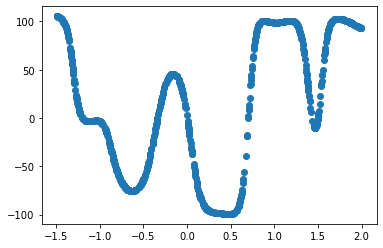

In [146]:
lossesSigmoid1 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [147]:
MSE(y_pred.flatten(), Y_test)

5.232931798634376

### Linear

In [148]:
nn = NeuralNetwork(1,[100,1],["linear","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00002)

In [149]:
nn.fit(X_train.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 4428.975041170067
Epoch 2/1000 - loss: 4422.38356402931
Epoch 3/1000 - loss: 4418.880719408358
Epoch 4/1000 - loss: 4412.914490246868
Epoch 5/1000 - loss: 4414.694167873955
Epoch 6/1000 - loss: 4409.100080176485
Epoch 7/1000 - loss: 4405.081682011931
Epoch 8/1000 - loss: 4409.239303041346
Epoch 9/1000 - loss: 4413.36459376274
Epoch 10/1000 - loss: 4415.14668518474
Epoch 11/1000 - loss: 4408.487389698634
Epoch 12/1000 - loss: 4406.204758925733
Epoch 13/1000 - loss: 4417.384837469576
Epoch 14/1000 - loss: 4414.963355528407
Epoch 15/1000 - loss: 4410.120779240955
Epoch 16/1000 - loss: 4406.733494215089
Epoch 17/1000 - loss: 4414.264676112015
Epoch 18/1000 - loss: 4413.529990853733
Epoch 19/1000 - loss: 4410.295026859577
Epoch 20/1000 - loss: 4409.057420456656
Epoch 21/1000 - loss: 4407.983861919893
Epoch 22/1000 - loss: 4409.564849712822
Epoch 23/1000 - loss: 4413.698982867993
Epoch 24/1000 - loss: 4411.808790024889
Epoch 25/1000 - loss: 4406.301126382612
Epoch 26/100

Epoch 204/1000 - loss: 4411.010837807957
Epoch 205/1000 - loss: 4408.056494391917
Epoch 206/1000 - loss: 4415.5611766562315
Epoch 207/1000 - loss: 4408.982479996889
Epoch 208/1000 - loss: 4404.273429016672
Epoch 209/1000 - loss: 4408.78687577551
Epoch 210/1000 - loss: 4415.427945742477
Epoch 211/1000 - loss: 4408.235949717983
Epoch 212/1000 - loss: 4410.316447749919
Epoch 213/1000 - loss: 4410.949581353655
Epoch 214/1000 - loss: 4410.977501818323
Epoch 215/1000 - loss: 4408.076313304426
Epoch 216/1000 - loss: 4409.742423222493
Epoch 217/1000 - loss: 4409.091951553682
Epoch 218/1000 - loss: 4411.892352991367
Epoch 219/1000 - loss: 4406.4583600313645
Epoch 220/1000 - loss: 4404.11511604615
Epoch 221/1000 - loss: 4412.503949037261
Epoch 222/1000 - loss: 4410.937453530892
Epoch 223/1000 - loss: 4410.547324979919
Epoch 224/1000 - loss: 4411.742558022156
Epoch 225/1000 - loss: 4408.005079126721
Epoch 226/1000 - loss: 4413.049962822652
Epoch 227/1000 - loss: 4416.284537761498
Epoch 228/1000 -

Epoch 404/1000 - loss: 4405.962778481539
Epoch 405/1000 - loss: 4408.572003130101
Epoch 406/1000 - loss: 4412.26118647452
Epoch 407/1000 - loss: 4416.820105931771
Epoch 408/1000 - loss: 4408.288403581457
Epoch 409/1000 - loss: 4406.214593476184
Epoch 410/1000 - loss: 4407.306545540709
Epoch 411/1000 - loss: 4409.509768497939
Epoch 412/1000 - loss: 4410.423424514508
Epoch 413/1000 - loss: 4404.631007540119
Epoch 414/1000 - loss: 4417.330738859807
Epoch 415/1000 - loss: 4406.7244194752575
Epoch 416/1000 - loss: 4408.819297773058
Epoch 417/1000 - loss: 4407.176480981927
Epoch 418/1000 - loss: 4405.393555755931
Epoch 419/1000 - loss: 4406.047708165067
Epoch 420/1000 - loss: 4402.184174747793
Epoch 421/1000 - loss: 4411.290722075329
Epoch 422/1000 - loss: 4402.596207593166
Epoch 423/1000 - loss: 4410.561364552866
Epoch 424/1000 - loss: 4411.989714705512
Epoch 425/1000 - loss: 4408.241533517661
Epoch 426/1000 - loss: 4410.651158736966
Epoch 427/1000 - loss: 4416.460120365995
Epoch 428/1000 -

Epoch 604/1000 - loss: 4410.325157080152
Epoch 605/1000 - loss: 4411.194490687883
Epoch 606/1000 - loss: 4409.913973133874
Epoch 607/1000 - loss: 4406.951668615009
Epoch 608/1000 - loss: 4407.476974647383
Epoch 609/1000 - loss: 4407.123358464561
Epoch 610/1000 - loss: 4409.359989174725
Epoch 611/1000 - loss: 4411.213340848187
Epoch 612/1000 - loss: 4406.897388705069
Epoch 613/1000 - loss: 4403.922453191954
Epoch 614/1000 - loss: 4409.08591291837
Epoch 615/1000 - loss: 4405.198577813251
Epoch 616/1000 - loss: 4407.638036989746
Epoch 617/1000 - loss: 4406.529029256753
Epoch 618/1000 - loss: 4407.343312976493
Epoch 619/1000 - loss: 4410.776108217296
Epoch 620/1000 - loss: 4405.743079570883
Epoch 621/1000 - loss: 4410.055595695793
Epoch 622/1000 - loss: 4405.958777248438
Epoch 623/1000 - loss: 4400.7196851311855
Epoch 624/1000 - loss: 4407.581766034755
Epoch 625/1000 - loss: 4409.795859411683
Epoch 626/1000 - loss: 4406.612880888888
Epoch 627/1000 - loss: 4409.336573418101
Epoch 628/1000 -

Epoch 804/1000 - loss: 4410.732527851398
Epoch 805/1000 - loss: 4409.505186701407
Epoch 806/1000 - loss: 4406.068048883665
Epoch 807/1000 - loss: 4410.606657841765
Epoch 808/1000 - loss: 4404.594786109784
Epoch 809/1000 - loss: 4410.262166728722
Epoch 810/1000 - loss: 4406.309307495594
Epoch 811/1000 - loss: 4407.38728669195
Epoch 812/1000 - loss: 4408.107339180373
Epoch 813/1000 - loss: 4404.646711513346
Epoch 814/1000 - loss: 4408.620930390525
Epoch 815/1000 - loss: 4406.499489095273
Epoch 816/1000 - loss: 4403.384849261004
Epoch 817/1000 - loss: 4406.548817205954
Epoch 818/1000 - loss: 4405.3237250508355
Epoch 819/1000 - loss: 4406.839164887343
Epoch 820/1000 - loss: 4405.601823278625
Epoch 821/1000 - loss: 4409.339951809636
Epoch 822/1000 - loss: 4402.930074706981
Epoch 823/1000 - loss: 4409.485434024316
Epoch 824/1000 - loss: 4409.277445385784
Epoch 825/1000 - loss: 4410.806907402351
Epoch 826/1000 - loss: 4406.241549232298
Epoch 827/1000 - loss: 4407.611673914385
Epoch 828/1000 -

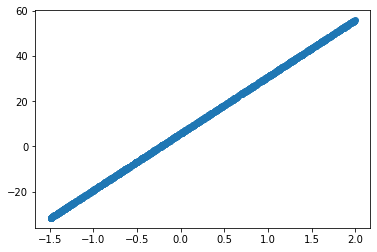

In [150]:
lossesLinear1 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [151]:
MSE(y_pred.flatten(), Y_test)

4445.621542684931

### tanh

In [152]:
nn = NeuralNetwork(1,[100,1],["tanh","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00002)

In [153]:
nn.fit(X_train.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 3809.1151025550544
Epoch 2/1000 - loss: 2540.1663865307924
Epoch 3/1000 - loss: 2030.7665038144723
Epoch 4/1000 - loss: 1680.1747156781842
Epoch 5/1000 - loss: 1416.505689054483
Epoch 6/1000 - loss: 1250.598109378107
Epoch 7/1000 - loss: 1148.891275098928
Epoch 8/1000 - loss: 1072.2852691718524
Epoch 9/1000 - loss: 1064.577820538246
Epoch 10/1000 - loss: 950.4194340567708
Epoch 11/1000 - loss: 870.2509853183424
Epoch 12/1000 - loss: 787.8366667719615
Epoch 13/1000 - loss: 714.1603240254504
Epoch 14/1000 - loss: 668.6297909120686
Epoch 15/1000 - loss: 553.7277742865379
Epoch 16/1000 - loss: 508.32149157774336
Epoch 17/1000 - loss: 466.15074898056287
Epoch 18/1000 - loss: 435.7043385278577
Epoch 19/1000 - loss: 409.0494935448471
Epoch 20/1000 - loss: 386.9855934831062
Epoch 21/1000 - loss: 370.1703178619259
Epoch 22/1000 - loss: 348.6415336125804
Epoch 23/1000 - loss: 342.3530847940958
Epoch 24/1000 - loss: 327.6497296232161
Epoch 25/1000 - loss: 310.90140268039625
E

Epoch 201/1000 - loss: 13.851882574144314
Epoch 202/1000 - loss: 9.13193908669185
Epoch 203/1000 - loss: 9.421597039969104
Epoch 204/1000 - loss: 9.826021038566637
Epoch 205/1000 - loss: 9.392867713328501
Epoch 206/1000 - loss: 8.963243768421183
Epoch 207/1000 - loss: 8.767869798663597
Epoch 208/1000 - loss: 10.318103990213652
Epoch 209/1000 - loss: 9.24309336149888
Epoch 210/1000 - loss: 8.86816891592537
Epoch 211/1000 - loss: 9.837120288278133
Epoch 212/1000 - loss: 8.455143942390235
Epoch 213/1000 - loss: 10.98602877842447
Epoch 214/1000 - loss: 8.739547483044731
Epoch 215/1000 - loss: 8.806166313726258
Epoch 216/1000 - loss: 8.507730617545272
Epoch 217/1000 - loss: 11.026643683108734
Epoch 218/1000 - loss: 10.49028731383183
Epoch 219/1000 - loss: 8.529800129937117
Epoch 220/1000 - loss: 8.19898736285375
Epoch 221/1000 - loss: 8.186874990371399
Epoch 222/1000 - loss: 9.165506062469174
Epoch 223/1000 - loss: 9.112979737626421
Epoch 224/1000 - loss: 10.040066567752575
Epoch 225/1000 -

Epoch 401/1000 - loss: 6.666044430967576
Epoch 402/1000 - loss: 6.462471892390751
Epoch 403/1000 - loss: 6.401122294702266
Epoch 404/1000 - loss: 6.340760874085333
Epoch 405/1000 - loss: 6.460531457677872
Epoch 406/1000 - loss: 6.877546035800068
Epoch 407/1000 - loss: 6.36668751039233
Epoch 408/1000 - loss: 6.432048515368055
Epoch 409/1000 - loss: 6.657691881671941
Epoch 410/1000 - loss: 6.369599330328131
Epoch 411/1000 - loss: 6.468512927169589
Epoch 412/1000 - loss: 6.472055537905465
Epoch 413/1000 - loss: 6.549411733320904
Epoch 414/1000 - loss: 6.6017611662156215
Epoch 415/1000 - loss: 6.350890891973177
Epoch 416/1000 - loss: 6.389955123329253
Epoch 417/1000 - loss: 7.357526234458353
Epoch 418/1000 - loss: 6.543207912891188
Epoch 419/1000 - loss: 6.398354533366964
Epoch 420/1000 - loss: 6.473332728397022
Epoch 421/1000 - loss: 6.405517900435648
Epoch 422/1000 - loss: 8.087718765070157
Epoch 423/1000 - loss: 6.2876854459447475
Epoch 424/1000 - loss: 6.438515524346668
Epoch 425/1000 

Epoch 601/1000 - loss: 5.964852471561185
Epoch 602/1000 - loss: 6.132480994447969
Epoch 603/1000 - loss: 6.5269240854983375
Epoch 604/1000 - loss: 5.96383025373278
Epoch 605/1000 - loss: 6.055957376626956
Epoch 606/1000 - loss: 6.011408220405134
Epoch 607/1000 - loss: 5.979927196877959
Epoch 608/1000 - loss: 5.908183219014567
Epoch 609/1000 - loss: 6.038051613724962
Epoch 610/1000 - loss: 6.043334560977024
Epoch 611/1000 - loss: 6.040987747936575
Epoch 612/1000 - loss: 5.8715635544536955
Epoch 613/1000 - loss: 6.272209996421983
Epoch 614/1000 - loss: 5.974022355024636
Epoch 615/1000 - loss: 5.9887637157741676
Epoch 616/1000 - loss: 5.956612981465865
Epoch 617/1000 - loss: 6.026767181759277
Epoch 618/1000 - loss: 5.9552560132205885
Epoch 619/1000 - loss: 6.0422646158967455
Epoch 620/1000 - loss: 6.013764603806112
Epoch 621/1000 - loss: 6.111355747624258
Epoch 622/1000 - loss: 6.006605802669982
Epoch 623/1000 - loss: 5.952888410977075
Epoch 624/1000 - loss: 5.964825360970785
Epoch 625/10

Epoch 801/1000 - loss: 5.847197641517135
Epoch 802/1000 - loss: 5.831619958936957
Epoch 803/1000 - loss: 5.76856188032952
Epoch 804/1000 - loss: 5.780295643341921
Epoch 805/1000 - loss: 5.6995114765573245
Epoch 806/1000 - loss: 5.83626848563007
Epoch 807/1000 - loss: 5.766249529403256
Epoch 808/1000 - loss: 5.8563281928376325
Epoch 809/1000 - loss: 5.896706507123858
Epoch 810/1000 - loss: 5.676888757592751
Epoch 811/1000 - loss: 5.769031695283816
Epoch 812/1000 - loss: 5.823173910235417
Epoch 813/1000 - loss: 5.840000278852182
Epoch 814/1000 - loss: 6.339027405884934
Epoch 815/1000 - loss: 5.73587986232932
Epoch 816/1000 - loss: 5.821702851888744
Epoch 817/1000 - loss: 5.710271740569743
Epoch 818/1000 - loss: 5.702875609289496
Epoch 819/1000 - loss: 5.773893551842894
Epoch 820/1000 - loss: 5.757301212405556
Epoch 821/1000 - loss: 5.887722382758707
Epoch 822/1000 - loss: 5.760222700537821
Epoch 823/1000 - loss: 5.802401256103818
Epoch 824/1000 - loss: 5.689944363278478
Epoch 825/1000 - 

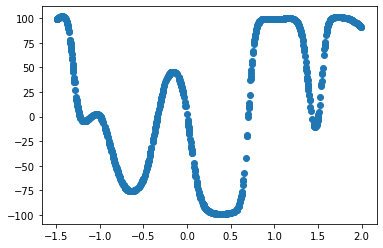

In [154]:
lossestanh1 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [155]:
MSE(y_pred.flatten(), Y_test)

2.1637310054370236

### ReLU

In [21]:
nn = NeuralNetwork(1,[100,1],["relu","linear"],["uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.000005)

In [ ]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 5987.749109788091
Epoch 2/1000 - loss: 6597.777828003703
Epoch 3/1000 - loss: 7024.006386125313
Epoch 4/1000 - loss: 7359.414253440067
Epoch 5/1000 - loss: 7516.610794957572
Epoch 6/1000 - loss: 7591.656781035641
Epoch 7/1000 - loss: 7575.536407249933
Epoch 8/1000 - loss: 7588.894525612692
Epoch 9/1000 - loss: 7598.741271833487
Epoch 10/1000 - loss: 7576.854420187482
Epoch 11/1000 - loss: 7592.290165104106
Epoch 12/1000 - loss: 7570.172040005639
Epoch 13/1000 - loss: 7603.215727748416
Epoch 14/1000 - loss: 7568.875260728976
Epoch 15/1000 - loss: 7570.144922541921
Epoch 16/1000 - loss: 7564.021199366314
Epoch 17/1000 - loss: 7598.463778839735
Epoch 18/1000 - loss: 7590.231036757724
Epoch 19/1000 - loss: 7578.404922770664
Epoch 20/1000 - loss: 7569.264134183488
Epoch 21/1000 - loss: 7548.191538861701
Epoch 22/1000 - loss: 7596.0345030525705
Epoch 23/1000 - loss: 7563.2074132572
Epoch 24/1000 - loss: 7567.501936826397
Epoch 25/1000 - loss: 7561.062927531078
Epoch 26/1

Epoch 204/1000 - loss: 7595.805716283594
Epoch 205/1000 - loss: 7642.9944383417605
Epoch 206/1000 - loss: 7626.169986391809
Epoch 207/1000 - loss: 7712.108503362423
Epoch 208/1000 - loss: 7640.781848690343
Epoch 209/1000 - loss: 7675.8995956061035
Epoch 210/1000 - loss: 7717.629814425073
Epoch 211/1000 - loss: 7685.740388775683
Epoch 212/1000 - loss: 7700.728978001374
Epoch 213/1000 - loss: 7767.2727279980845
Epoch 214/1000 - loss: 7689.434479036405
Epoch 215/1000 - loss: 7695.922972965187
Epoch 216/1000 - loss: 7676.776407435278
Epoch 217/1000 - loss: 7700.379259416339
Epoch 218/1000 - loss: 7631.599484332286
Epoch 219/1000 - loss: 7704.383944024717
Epoch 220/1000 - loss: 7638.65936970883
Epoch 221/1000 - loss: 7731.867985030059
Epoch 222/1000 - loss: 7701.10999414879
Epoch 223/1000 - loss: 7641.5046155372365
Epoch 224/1000 - loss: 7658.559174015593
Epoch 225/1000 - loss: 7741.068144246699
Epoch 226/1000 - loss: 7654.839683350313
Epoch 227/1000 - loss: 7659.237417204096
Epoch 228/1000

Epoch 404/1000 - loss: 7717.35306106171
Epoch 405/1000 - loss: 7648.328385052676
Epoch 406/1000 - loss: 7697.526997392976
Epoch 407/1000 - loss: 7690.995708857637
Epoch 408/1000 - loss: 7742.963070484299
Epoch 409/1000 - loss: 7642.207565641786
Epoch 410/1000 - loss: 7728.56682915433
Epoch 411/1000 - loss: 7729.019786436267
Epoch 412/1000 - loss: 7662.006612690608
Epoch 413/1000 - loss: 7683.119689418489
Epoch 414/1000 - loss: 7652.47716539992
Epoch 415/1000 - loss: 7685.704086494499
Epoch 416/1000 - loss: 7660.154566198004
Epoch 417/1000 - loss: 7729.363804474424
Epoch 418/1000 - loss: 7614.992789299219
Epoch 419/1000 - loss: 7725.565948716027
Epoch 420/1000 - loss: 7707.149213175117
Epoch 421/1000 - loss: 7626.205208294312
Epoch 422/1000 - loss: 7694.647380039111
Epoch 423/1000 - loss: 7677.520268006807
Epoch 424/1000 - loss: 7700.866643146837
Epoch 425/1000 - loss: 7637.777797829939
Epoch 426/1000 - loss: 7659.027099397428
Epoch 427/1000 - loss: 7706.82780975933
Epoch 428/1000 - los

Epoch 605/1000 - loss: 7676.225836522529
Epoch 606/1000 - loss: 7724.097806341294
Epoch 607/1000 - loss: 7647.7913311606435
Epoch 608/1000 - loss: 7735.615939157432
Epoch 609/1000 - loss: 7646.909155695541
Epoch 610/1000 - loss: 7687.412722125588
Epoch 611/1000 - loss: 7651.316144857864
Epoch 612/1000 - loss: 7683.359467617019
Epoch 613/1000 - loss: 7675.7007421282115
Epoch 614/1000 - loss: 7635.622776532514
Epoch 615/1000 - loss: 7686.430076709184
Epoch 616/1000 - loss: 7674.943112335958
Epoch 617/1000 - loss: 7675.106794376388
Epoch 618/1000 - loss: 7683.331179230613
Epoch 619/1000 - loss: 7698.490342508346
Epoch 620/1000 - loss: 7713.632202185575
Epoch 621/1000 - loss: 7688.972148221445
Epoch 622/1000 - loss: 7904.450129746289
Epoch 623/1000 - loss: 7695.652231072437
Epoch 624/1000 - loss: 7615.143483971008
Epoch 625/1000 - loss: 7673.465796967553
Epoch 626/1000 - loss: 7681.778374663528
Epoch 627/1000 - loss: 7678.871716208046
Epoch 628/1000 - loss: 7691.12321760019
Epoch 629/1000 

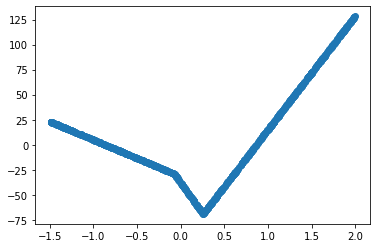

In [138]:
lossesRelu1 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [139]:
MSE(y_pred.flatten(), Y_test)

2729.6356502760596

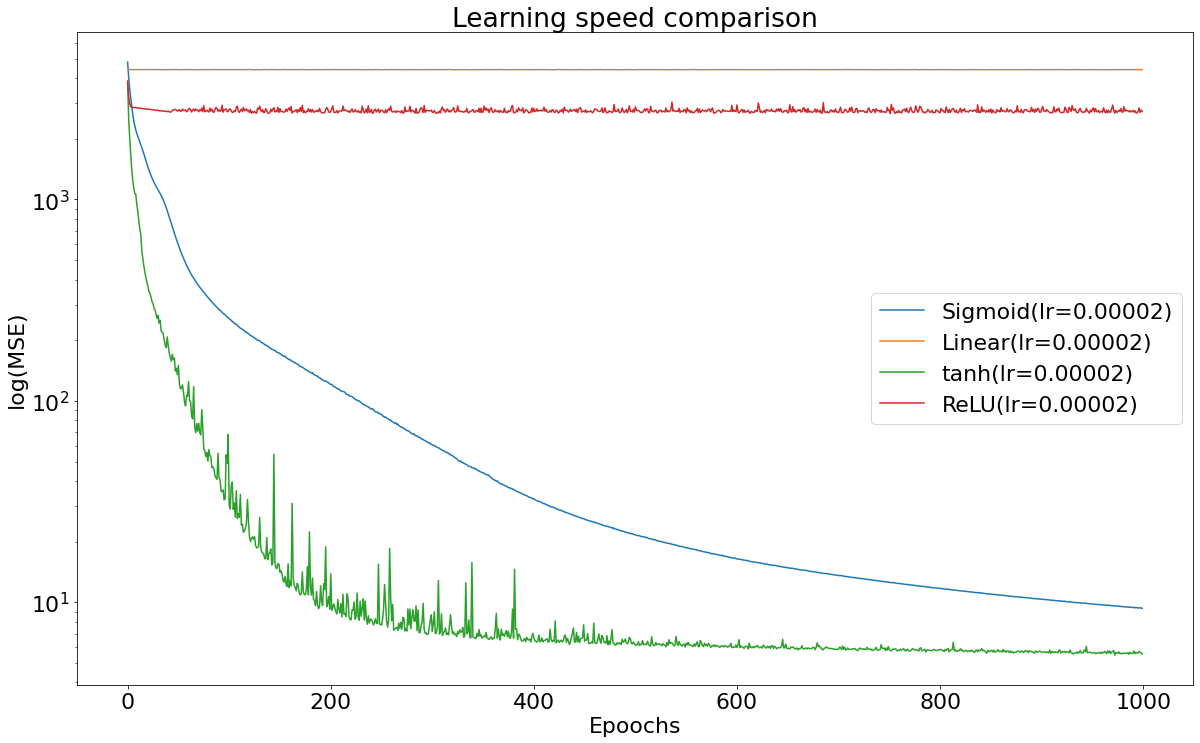

In [156]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 22})
plt.plot(lossesSigmoid1,label="Sigmoid(lr=0.00002)")
plt.plot(lossesLinear1,label="Linear(lr=0.00002)")
plt.plot(lossestanh1,label="tanh(lr=0.00002)")
plt.plot(lossesRelu1,label="ReLU(lr=0.00002)")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()

## 2 hidden layers

### Sigmoid

In [16]:
nn = NeuralNetwork(1,[20,20,1],["sigmoid","sigmoid","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00002)

In [17]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 5179.404495183502
Epoch 2/1000 - loss: 5181.291205255756
Epoch 3/1000 - loss: 5179.122699397227
Epoch 4/1000 - loss: 5178.174011122008
Epoch 5/1000 - loss: 5177.1059230077635
Epoch 6/1000 - loss: 5149.586035438413
Epoch 7/1000 - loss: 4939.477370268558
Epoch 8/1000 - loss: 4543.418263574511
Epoch 9/1000 - loss: 3958.7065429489994
Epoch 10/1000 - loss: 3419.8547596276267
Epoch 11/1000 - loss: 3020.4134905573555
Epoch 12/1000 - loss: 2767.6113172685596
Epoch 13/1000 - loss: 2645.2599535900026
Epoch 14/1000 - loss: 2577.5956971268706
Epoch 15/1000 - loss: 2534.738871328206
Epoch 16/1000 - loss: 2408.2550303058774
Epoch 17/1000 - loss: 2220.861817945037
Epoch 18/1000 - loss: 2059.201291567552
Epoch 19/1000 - loss: 1915.306517276996
Epoch 20/1000 - loss: 1845.9425156608104
Epoch 21/1000 - loss: 1744.901421611188
Epoch 22/1000 - loss: 1685.678022337774
Epoch 23/1000 - loss: 1636.476895666414
Epoch 24/1000 - loss: 1624.0829638038567
Epoch 25/1000 - loss: 1576.719414244426

Epoch 202/1000 - loss: 415.2028675353573
Epoch 203/1000 - loss: 418.7999514525261
Epoch 204/1000 - loss: 401.59584635123264
Epoch 205/1000 - loss: 404.9044941588826
Epoch 206/1000 - loss: 397.652065348529
Epoch 207/1000 - loss: 426.0504443181133
Epoch 208/1000 - loss: 398.97899439263495
Epoch 209/1000 - loss: 405.69870307334213
Epoch 210/1000 - loss: 401.35680051680566
Epoch 211/1000 - loss: 405.36456402001323
Epoch 212/1000 - loss: 401.85140864534077
Epoch 213/1000 - loss: 381.24685028619086
Epoch 214/1000 - loss: 380.384286434406
Epoch 215/1000 - loss: 392.2989497820131
Epoch 216/1000 - loss: 391.7993251102224
Epoch 217/1000 - loss: 390.0147463468074
Epoch 218/1000 - loss: 387.5175597044299
Epoch 219/1000 - loss: 400.5927251229169
Epoch 220/1000 - loss: 387.04652624152544
Epoch 221/1000 - loss: 401.96445279940366
Epoch 222/1000 - loss: 374.4968834343114
Epoch 223/1000 - loss: 393.0859758622093
Epoch 224/1000 - loss: 394.29743117168204
Epoch 225/1000 - loss: 373.953850229731
Epoch 226

Epoch 401/1000 - loss: 346.4125992345906
Epoch 402/1000 - loss: 323.373085549873
Epoch 403/1000 - loss: 330.4092413509123
Epoch 404/1000 - loss: 322.57616314190216
Epoch 405/1000 - loss: 326.16866089691433
Epoch 406/1000 - loss: 339.61953151759633
Epoch 407/1000 - loss: 327.77483245307684
Epoch 408/1000 - loss: 330.5544598050599
Epoch 409/1000 - loss: 324.07327176590405
Epoch 410/1000 - loss: 343.8662725641948
Epoch 411/1000 - loss: 340.5296440744547
Epoch 412/1000 - loss: 334.92438695695245
Epoch 413/1000 - loss: 325.4110353662061
Epoch 414/1000 - loss: 328.2762617218579
Epoch 415/1000 - loss: 318.0011290573793
Epoch 416/1000 - loss: 333.2903988227694
Epoch 417/1000 - loss: 343.0388910594826
Epoch 418/1000 - loss: 325.07918584948845
Epoch 419/1000 - loss: 333.0932120512058
Epoch 420/1000 - loss: 324.4619601403104
Epoch 421/1000 - loss: 325.8899656990629
Epoch 422/1000 - loss: 336.20871164219244
Epoch 423/1000 - loss: 341.1645753130801
Epoch 424/1000 - loss: 332.5557480109298
Epoch 425

Epoch 600/1000 - loss: 328.12034836630306
Epoch 601/1000 - loss: 323.44757501452295
Epoch 602/1000 - loss: 328.51353138478413
Epoch 603/1000 - loss: 313.49738114841256
Epoch 604/1000 - loss: 323.6178481638509
Epoch 605/1000 - loss: 324.0531517684065
Epoch 606/1000 - loss: 314.8880099955246
Epoch 607/1000 - loss: 324.9670461248289
Epoch 608/1000 - loss: 316.7899972024372
Epoch 609/1000 - loss: 320.8116285914783
Epoch 610/1000 - loss: 320.0952697094356
Epoch 611/1000 - loss: 322.057397911527
Epoch 612/1000 - loss: 336.02315125894853
Epoch 613/1000 - loss: 319.66704117846194
Epoch 614/1000 - loss: 311.3353987642948
Epoch 615/1000 - loss: 320.6057128569788
Epoch 616/1000 - loss: 321.75947643700493
Epoch 617/1000 - loss: 327.8981005610289
Epoch 618/1000 - loss: 332.4570007818174
Epoch 619/1000 - loss: 330.7151094205847
Epoch 620/1000 - loss: 322.77036740290345
Epoch 621/1000 - loss: 328.1233626894373
Epoch 622/1000 - loss: 318.09271918887384
Epoch 623/1000 - loss: 318.1521749850987
Epoch 62

Epoch 799/1000 - loss: 309.9387324332362
Epoch 800/1000 - loss: 323.60497228510155
Epoch 801/1000 - loss: 312.7415692239455
Epoch 802/1000 - loss: 320.17916669862393
Epoch 803/1000 - loss: 308.84774785675046
Epoch 804/1000 - loss: 320.21302915306853
Epoch 805/1000 - loss: 317.7919093110895
Epoch 806/1000 - loss: 309.7112604667409
Epoch 807/1000 - loss: 313.2567076315874
Epoch 808/1000 - loss: 323.95458812029744
Epoch 809/1000 - loss: 304.81065906333856
Epoch 810/1000 - loss: 318.5494702267853
Epoch 811/1000 - loss: 314.7813345763876
Epoch 812/1000 - loss: 314.23004645444036
Epoch 813/1000 - loss: 326.75779018934816
Epoch 814/1000 - loss: 312.21800271308757
Epoch 815/1000 - loss: 317.9085795997414
Epoch 816/1000 - loss: 310.3990296581312
Epoch 817/1000 - loss: 313.25611897916855
Epoch 818/1000 - loss: 321.38746419899036
Epoch 819/1000 - loss: 319.2715326556303
Epoch 820/1000 - loss: 312.50351998564514
Epoch 821/1000 - loss: 309.5117820530011
Epoch 822/1000 - loss: 326.74865614127793
Epo

Epoch 998/1000 - loss: 312.9312586803361
Epoch 999/1000 - loss: 311.05892466696235
Epoch 1000/1000 - loss: 320.9102706568657


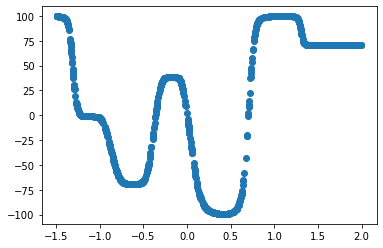

In [18]:
lossesSigmoid2 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [19]:
MSE(y_pred.flatten(), Y_test)

331.5022481678666

### Linear

In [20]:
nn = NeuralNetwork(1,[20,20,1],["linear","linear","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00001)

In [21]:
nn.fit(X_train.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 5182.30018914387
Epoch 2/1000 - loss: 4529.6528352529795
Epoch 3/1000 - loss: 4483.012442734335
Epoch 4/1000 - loss: 4453.989569278264
Epoch 5/1000 - loss: 4434.957182769076
Epoch 6/1000 - loss: 4421.664413658076
Epoch 7/1000 - loss: 4413.3483568579495
Epoch 8/1000 - loss: 4408.050142403057
Epoch 9/1000 - loss: 4404.523329237876
Epoch 10/1000 - loss: 4402.450471428232
Epoch 11/1000 - loss: 4400.8103085418625
Epoch 12/1000 - loss: 4399.925668519805
Epoch 13/1000 - loss: 4399.769607086023
Epoch 14/1000 - loss: 4399.337311675674
Epoch 15/1000 - loss: 4399.205429994952
Epoch 16/1000 - loss: 4398.663622345137
Epoch 17/1000 - loss: 4399.150894007254
Epoch 18/1000 - loss: 4398.922789109749
Epoch 19/1000 - loss: 4399.037880653955
Epoch 20/1000 - loss: 4398.780249702171
Epoch 21/1000 - loss: 4398.858349492173
Epoch 22/1000 - loss: 4398.754394110043
Epoch 23/1000 - loss: 4399.019156300051
Epoch 24/1000 - loss: 4398.748756972024
Epoch 25/1000 - loss: 4398.748725400928
Epoch 2

Epoch 204/1000 - loss: 4398.777314175346
Epoch 205/1000 - loss: 4398.982273625524
Epoch 206/1000 - loss: 4399.103973457984
Epoch 207/1000 - loss: 4398.834877231814
Epoch 208/1000 - loss: 4398.864639908667
Epoch 209/1000 - loss: 4398.872694791516
Epoch 210/1000 - loss: 4399.071433787165
Epoch 211/1000 - loss: 4398.833772899204
Epoch 212/1000 - loss: 4398.81658652854
Epoch 213/1000 - loss: 4398.849950470384
Epoch 214/1000 - loss: 4398.7703500571
Epoch 215/1000 - loss: 4399.021246791755
Epoch 216/1000 - loss: 4398.761432561055
Epoch 217/1000 - loss: 4398.805520174834
Epoch 218/1000 - loss: 4398.950926370886
Epoch 219/1000 - loss: 4398.836890973986
Epoch 220/1000 - loss: 4398.6308770113055
Epoch 221/1000 - loss: 4398.865865070039
Epoch 222/1000 - loss: 4398.902685543356
Epoch 223/1000 - loss: 4398.880112709999
Epoch 224/1000 - loss: 4398.912120482353
Epoch 225/1000 - loss: 4398.793803306404
Epoch 226/1000 - loss: 4399.049521846624
Epoch 227/1000 - loss: 4399.111018046041
Epoch 228/1000 - l

Epoch 404/1000 - loss: 4398.789676509756
Epoch 405/1000 - loss: 4398.7007164351835
Epoch 406/1000 - loss: 4399.002709421296
Epoch 407/1000 - loss: 4398.927284558355
Epoch 408/1000 - loss: 4398.896620831538
Epoch 409/1000 - loss: 4398.860123824105
Epoch 410/1000 - loss: 4398.801545399808
Epoch 411/1000 - loss: 4398.782875884861
Epoch 412/1000 - loss: 4398.886305081017
Epoch 413/1000 - loss: 4398.734390365015
Epoch 414/1000 - loss: 4398.859225755757
Epoch 415/1000 - loss: 4398.877893728436
Epoch 416/1000 - loss: 4398.810825853569
Epoch 417/1000 - loss: 4398.657641430764
Epoch 418/1000 - loss: 4398.8623684204385
Epoch 419/1000 - loss: 4398.6675155436305
Epoch 420/1000 - loss: 4398.756680439667
Epoch 421/1000 - loss: 4398.98156725536
Epoch 422/1000 - loss: 4398.5794394793165
Epoch 423/1000 - loss: 4399.039814674075
Epoch 424/1000 - loss: 4398.875785533721
Epoch 425/1000 - loss: 4398.7439706189525
Epoch 426/1000 - loss: 4398.837027148581
Epoch 427/1000 - loss: 4398.987722657437
Epoch 428/10

Epoch 604/1000 - loss: 4398.849388723483
Epoch 605/1000 - loss: 4398.885961374313
Epoch 606/1000 - loss: 4398.770538333628
Epoch 607/1000 - loss: 4398.752008812265
Epoch 608/1000 - loss: 4399.042164296183
Epoch 609/1000 - loss: 4398.76662789728
Epoch 610/1000 - loss: 4398.710462532744
Epoch 611/1000 - loss: 4398.996803365944
Epoch 612/1000 - loss: 4398.623837699959
Epoch 613/1000 - loss: 4398.570618717021
Epoch 614/1000 - loss: 4398.782464595127
Epoch 615/1000 - loss: 4398.653176461662
Epoch 616/1000 - loss: 4398.705103521396
Epoch 617/1000 - loss: 4398.817991886069
Epoch 618/1000 - loss: 4398.814613814603
Epoch 619/1000 - loss: 4398.838584029427
Epoch 620/1000 - loss: 4398.731799335083
Epoch 621/1000 - loss: 4398.845667613495
Epoch 622/1000 - loss: 4398.7348021498165
Epoch 623/1000 - loss: 4398.692508864833
Epoch 624/1000 - loss: 4398.843001121684
Epoch 625/1000 - loss: 4398.7978404377845
Epoch 626/1000 - loss: 4399.091723901519
Epoch 627/1000 - loss: 4398.957561449579
Epoch 628/1000 

Epoch 804/1000 - loss: 4398.897935232444
Epoch 805/1000 - loss: 4398.822743939539
Epoch 806/1000 - loss: 4398.830638122085
Epoch 807/1000 - loss: 4398.854755909385
Epoch 808/1000 - loss: 4398.805203571502
Epoch 809/1000 - loss: 4398.823287443377
Epoch 810/1000 - loss: 4398.755335749326
Epoch 811/1000 - loss: 4398.770297801363
Epoch 812/1000 - loss: 4398.777728337325
Epoch 813/1000 - loss: 4398.787191405987
Epoch 814/1000 - loss: 4398.655884294135
Epoch 815/1000 - loss: 4398.620836029897
Epoch 816/1000 - loss: 4398.70633198349
Epoch 817/1000 - loss: 4398.977751543244
Epoch 818/1000 - loss: 4398.51079459829
Epoch 819/1000 - loss: 4398.88793296377
Epoch 820/1000 - loss: 4398.808220125727
Epoch 821/1000 - loss: 4398.798552713682
Epoch 822/1000 - loss: 4398.631142209305
Epoch 823/1000 - loss: 4398.866616799169
Epoch 824/1000 - loss: 4398.805026622977
Epoch 825/1000 - loss: 4399.118270930261
Epoch 826/1000 - loss: 4398.684981433957
Epoch 827/1000 - loss: 4398.740390870176
Epoch 828/1000 - lo

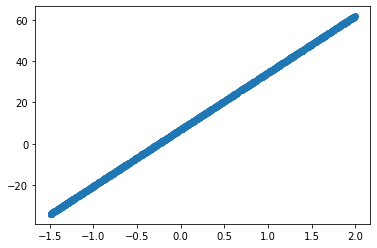

In [22]:
lossesLinear2 = nn.losses
y_pred = nn.predict(X_test)
plt.scatter(X_test, y_pred)
plt.show()

In [23]:
MSE(y_pred, Y_test)

5999.7868103569335

### tanh

In [24]:
nn = NeuralNetwork(1,[20,20,1],["tanh","tanh","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00001)

In [25]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 4475.587513719032
Epoch 2/1000 - loss: 2625.480498455415
Epoch 3/1000 - loss: 1783.0105767510943
Epoch 4/1000 - loss: 1394.1879475179155
Epoch 5/1000 - loss: 1318.0606611180967
Epoch 6/1000 - loss: 1161.1390530772514
Epoch 7/1000 - loss: 1159.5245794081723
Epoch 8/1000 - loss: 1164.380327379005
Epoch 9/1000 - loss: 1105.6751801796704
Epoch 10/1000 - loss: 1085.1885355320446
Epoch 11/1000 - loss: 1070.9686478102242
Epoch 12/1000 - loss: 1055.2677592473112
Epoch 13/1000 - loss: 1085.5751049940961
Epoch 14/1000 - loss: 1032.4955274361216
Epoch 15/1000 - loss: 1038.9823827084144
Epoch 16/1000 - loss: 1067.4441809550137
Epoch 17/1000 - loss: 995.4654689241786
Epoch 18/1000 - loss: 1018.0439520112812
Epoch 19/1000 - loss: 957.8553126848262
Epoch 20/1000 - loss: 958.1291523249245
Epoch 21/1000 - loss: 962.7229138875898
Epoch 22/1000 - loss: 977.5207657565069
Epoch 23/1000 - loss: 930.1597243000621
Epoch 24/1000 - loss: 914.2392259800315
Epoch 25/1000 - loss: 933.787673717

Epoch 204/1000 - loss: 829.927617358969
Epoch 205/1000 - loss: 829.9280380256506
Epoch 206/1000 - loss: 830.0705678863665
Epoch 207/1000 - loss: 829.9749546385577
Epoch 208/1000 - loss: 829.8857067627238
Epoch 209/1000 - loss: 829.8828032573555
Epoch 210/1000 - loss: 829.9413688958077
Epoch 211/1000 - loss: 829.9250910689326
Epoch 212/1000 - loss: 829.9662992085011
Epoch 213/1000 - loss: 830.0216542724902
Epoch 214/1000 - loss: 829.9914654735369
Epoch 215/1000 - loss: 829.7700246200777
Epoch 216/1000 - loss: 830.0174089692416
Epoch 217/1000 - loss: 830.4773627435482
Epoch 218/1000 - loss: 830.0047399418514
Epoch 219/1000 - loss: 829.9998218941067
Epoch 220/1000 - loss: 829.9843229731365
Epoch 221/1000 - loss: 830.1043787800498
Epoch 222/1000 - loss: 830.2257565139745
Epoch 223/1000 - loss: 829.9413396814011
Epoch 224/1000 - loss: 829.8774257199746
Epoch 225/1000 - loss: 829.9759605880619
Epoch 226/1000 - loss: 829.9005933136807
Epoch 227/1000 - loss: 829.9819418110029
Epoch 228/1000 - 

Epoch 405/1000 - loss: 829.8519852704007
Epoch 406/1000 - loss: 829.6312182670431
Epoch 407/1000 - loss: 829.661569528207
Epoch 408/1000 - loss: 829.7389956298235
Epoch 409/1000 - loss: 829.7125033674471
Epoch 410/1000 - loss: 829.747546796265
Epoch 411/1000 - loss: 830.061670996364
Epoch 412/1000 - loss: 829.6218863277282
Epoch 413/1000 - loss: 829.6725345644021
Epoch 414/1000 - loss: 829.6958001222258
Epoch 415/1000 - loss: 829.6926992807663
Epoch 416/1000 - loss: 829.6977148980515
Epoch 417/1000 - loss: 833.0413720248096
Epoch 418/1000 - loss: 829.5695662759628
Epoch 419/1000 - loss: 829.7224013548172
Epoch 420/1000 - loss: 829.8036967075549
Epoch 421/1000 - loss: 829.6942967801925
Epoch 422/1000 - loss: 829.3732716116311
Epoch 423/1000 - loss: 828.3772610022711
Epoch 424/1000 - loss: 823.8786113864835
Epoch 425/1000 - loss: 813.2203467236607
Epoch 426/1000 - loss: 810.6648062353694
Epoch 427/1000 - loss: 807.6168052597219
Epoch 428/1000 - loss: 812.8664704249373
Epoch 429/1000 - lo

Epoch 604/1000 - loss: 112.2082333419777
Epoch 605/1000 - loss: 115.4583140611002
Epoch 606/1000 - loss: 118.737777723678
Epoch 607/1000 - loss: 107.42974636432272
Epoch 608/1000 - loss: 102.37347514687367
Epoch 609/1000 - loss: 98.1729423750998
Epoch 610/1000 - loss: 108.6956714554839
Epoch 611/1000 - loss: 94.90727544240231
Epoch 612/1000 - loss: 148.7292000833948
Epoch 613/1000 - loss: 102.94396322424234
Epoch 614/1000 - loss: 90.05357262299609
Epoch 615/1000 - loss: 106.0171395097566
Epoch 616/1000 - loss: 92.04088689159626
Epoch 617/1000 - loss: 101.1556690146585
Epoch 618/1000 - loss: 101.88247091518438
Epoch 619/1000 - loss: 83.97364268268026
Epoch 620/1000 - loss: 106.98185144348469
Epoch 621/1000 - loss: 92.53161989273916
Epoch 622/1000 - loss: 85.04115910501514
Epoch 623/1000 - loss: 96.78021149965133
Epoch 624/1000 - loss: 91.67443397571705
Epoch 625/1000 - loss: 89.70675743365017
Epoch 626/1000 - loss: 93.07010882526912
Epoch 627/1000 - loss: 87.65466984291086
Epoch 628/100

Epoch 803/1000 - loss: 48.20662255422096
Epoch 804/1000 - loss: 31.58841954329688
Epoch 805/1000 - loss: 24.66453627193751
Epoch 806/1000 - loss: 29.34660979430027
Epoch 807/1000 - loss: 32.9442031452116
Epoch 808/1000 - loss: 32.77508852050877
Epoch 809/1000 - loss: 25.523855726952032
Epoch 810/1000 - loss: 27.283851587510917
Epoch 811/1000 - loss: 30.78192785140987
Epoch 812/1000 - loss: 36.16488553729
Epoch 813/1000 - loss: 33.39887151991597
Epoch 814/1000 - loss: 29.424945600661705
Epoch 815/1000 - loss: 25.03623181357941
Epoch 816/1000 - loss: 32.220238570188926
Epoch 817/1000 - loss: 33.586821803500804
Epoch 818/1000 - loss: 31.23529769458605
Epoch 819/1000 - loss: 27.977508966696966
Epoch 820/1000 - loss: 33.2139151483748
Epoch 821/1000 - loss: 37.19683729365161
Epoch 822/1000 - loss: 28.975242866697016
Epoch 823/1000 - loss: 35.875253088209185
Epoch 824/1000 - loss: 23.032259319007792
Epoch 825/1000 - loss: 35.7160630549034
Epoch 826/1000 - loss: 26.01305649099066
Epoch 827/100

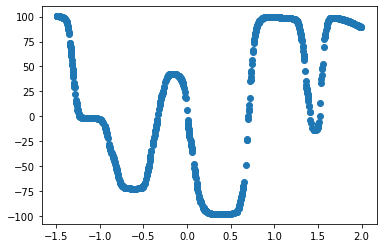

In [26]:
lossestanh2 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [27]:
MSE(y_pred.flatten(), Y_test)

18.158666867798303

### ReLU

In [28]:
nn = NeuralNetwork(1,[20,20,1],["relu","relu","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.000004)

In [29]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 3967.542781926981
Epoch 2/1000 - loss: 3178.38923351927
Epoch 3/1000 - loss: 2973.9563875585873
Epoch 4/1000 - loss: 3062.5527976838703
Epoch 5/1000 - loss: 2753.1870725586987
Epoch 6/1000 - loss: 2481.5794170742906
Epoch 7/1000 - loss: 2125.1505301865814
Epoch 8/1000 - loss: 2059.107225888996
Epoch 9/1000 - loss: 2096.306263637824
Epoch 10/1000 - loss: 1972.53186429389
Epoch 11/1000 - loss: 1895.9845544133398
Epoch 12/1000 - loss: 1838.5465238365623
Epoch 13/1000 - loss: 1601.7064132347207
Epoch 14/1000 - loss: 1712.3928108985115
Epoch 15/1000 - loss: 1447.9031832966532
Epoch 16/1000 - loss: 1508.7495421609517
Epoch 17/1000 - loss: 1450.7665467235117
Epoch 18/1000 - loss: 1485.899914867674
Epoch 19/1000 - loss: 1464.167295814873
Epoch 20/1000 - loss: 1400.4613560844166
Epoch 21/1000 - loss: 1451.6470710785125
Epoch 22/1000 - loss: 1280.3299947179573
Epoch 23/1000 - loss: 1524.0175836631865
Epoch 24/1000 - loss: 1479.829651227138
Epoch 25/1000 - loss: 1351.72296039

Epoch 201/1000 - loss: 172.1519797005574
Epoch 202/1000 - loss: 145.65168577837315
Epoch 203/1000 - loss: 136.12777819349435
Epoch 204/1000 - loss: 158.51548973030563
Epoch 205/1000 - loss: 152.27303478005578
Epoch 206/1000 - loss: 124.76813448603042
Epoch 207/1000 - loss: 141.9061716773247
Epoch 208/1000 - loss: 132.48509525870992
Epoch 209/1000 - loss: 148.51758069740745
Epoch 210/1000 - loss: 122.04672732736152
Epoch 211/1000 - loss: 128.3688421540985
Epoch 212/1000 - loss: 126.15729707924258
Epoch 213/1000 - loss: 152.26603491052597
Epoch 214/1000 - loss: 133.9248684985049
Epoch 215/1000 - loss: 154.3765321902697
Epoch 216/1000 - loss: 146.44964213531284
Epoch 217/1000 - loss: 128.78284767355143
Epoch 218/1000 - loss: 139.7198590561398
Epoch 219/1000 - loss: 131.6119508916045
Epoch 220/1000 - loss: 134.80311847031314
Epoch 221/1000 - loss: 131.81707790978882
Epoch 222/1000 - loss: 133.1139980270824
Epoch 223/1000 - loss: 126.34473711403176
Epoch 224/1000 - loss: 130.67345794851525


Epoch 398/1000 - loss: 127.54405780114601
Epoch 399/1000 - loss: 136.49146357286176
Epoch 400/1000 - loss: 119.01440001350569
Epoch 401/1000 - loss: 135.4705185610438
Epoch 402/1000 - loss: 122.49948638067625
Epoch 403/1000 - loss: 119.68805692834123
Epoch 404/1000 - loss: 120.32985113003929
Epoch 405/1000 - loss: 116.65556492977873
Epoch 406/1000 - loss: 125.238910730691
Epoch 407/1000 - loss: 124.93545036437544
Epoch 408/1000 - loss: 121.93191881519847
Epoch 409/1000 - loss: 126.99215314895139
Epoch 410/1000 - loss: 120.33784791748694
Epoch 411/1000 - loss: 119.06066416476119
Epoch 412/1000 - loss: 135.04351684991434
Epoch 413/1000 - loss: 132.54397842392808
Epoch 414/1000 - loss: 120.23832667265013
Epoch 415/1000 - loss: 119.88493184260058
Epoch 416/1000 - loss: 121.18644364681407
Epoch 417/1000 - loss: 127.29823525512039
Epoch 418/1000 - loss: 117.73007408892428
Epoch 419/1000 - loss: 132.30936871501177
Epoch 420/1000 - loss: 127.41514803074273
Epoch 421/1000 - loss: 119.5513834020

Epoch 595/1000 - loss: 116.56180811951482
Epoch 596/1000 - loss: 126.10369869384715
Epoch 597/1000 - loss: 121.61143189888064
Epoch 598/1000 - loss: 124.3663020529708
Epoch 599/1000 - loss: 124.78124933934356
Epoch 600/1000 - loss: 117.31539708660857
Epoch 601/1000 - loss: 118.89123030248768
Epoch 602/1000 - loss: 119.53136677156562
Epoch 603/1000 - loss: 117.72423300730372
Epoch 604/1000 - loss: 118.49097146572439
Epoch 605/1000 - loss: 118.7926753881141
Epoch 606/1000 - loss: 122.43300726799559
Epoch 607/1000 - loss: 119.33750080430436
Epoch 608/1000 - loss: 118.22787120421326
Epoch 609/1000 - loss: 120.24513654559233
Epoch 610/1000 - loss: 137.33065981899776
Epoch 611/1000 - loss: 118.99137734298189
Epoch 612/1000 - loss: 116.11796798477366
Epoch 613/1000 - loss: 118.77581885777046
Epoch 614/1000 - loss: 122.47522837715793
Epoch 615/1000 - loss: 121.65730296254799
Epoch 616/1000 - loss: 117.22126621495306
Epoch 617/1000 - loss: 119.22167777624784
Epoch 618/1000 - loss: 126.712433190

Epoch 792/1000 - loss: 116.15106230182177
Epoch 793/1000 - loss: 125.22157512967368
Epoch 794/1000 - loss: 119.37618544284393
Epoch 795/1000 - loss: 132.8395712438005
Epoch 796/1000 - loss: 116.05985646160222
Epoch 797/1000 - loss: 125.2705148446274
Epoch 798/1000 - loss: 117.46570141058768
Epoch 799/1000 - loss: 115.58164983732132
Epoch 800/1000 - loss: 120.15221085383835
Epoch 801/1000 - loss: 117.37891530991821
Epoch 802/1000 - loss: 116.62067829000694
Epoch 803/1000 - loss: 135.57660638470395
Epoch 804/1000 - loss: 116.482858352375
Epoch 805/1000 - loss: 115.66873213930812
Epoch 806/1000 - loss: 116.26722496810322
Epoch 807/1000 - loss: 114.90384313772873
Epoch 808/1000 - loss: 120.51934369308744
Epoch 809/1000 - loss: 116.64180061457434
Epoch 810/1000 - loss: 114.98689785397272
Epoch 811/1000 - loss: 122.56162509119633
Epoch 812/1000 - loss: 120.3497950730057
Epoch 813/1000 - loss: 114.5741100843364
Epoch 814/1000 - loss: 119.38192600105307
Epoch 815/1000 - loss: 117.0368316769111

Epoch 988/1000 - loss: 119.16888999302103
Epoch 989/1000 - loss: 120.31267940296722
Epoch 990/1000 - loss: 122.90472777705584
Epoch 991/1000 - loss: 118.23908985773966
Epoch 992/1000 - loss: 120.7031688112596
Epoch 993/1000 - loss: 116.32890972140348
Epoch 994/1000 - loss: 122.31468634752561
Epoch 995/1000 - loss: 116.17672002279214
Epoch 996/1000 - loss: 116.44425530684174
Epoch 997/1000 - loss: 128.89759091420933
Epoch 998/1000 - loss: 122.38147025397727
Epoch 999/1000 - loss: 115.25159893183215
Epoch 1000/1000 - loss: 118.5269249988798


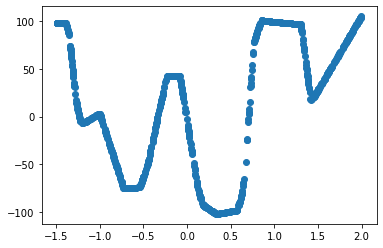

In [30]:
lossesRelu2 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [31]:
MSE(y_pred.flatten(), Y_test)

145.9397457552195

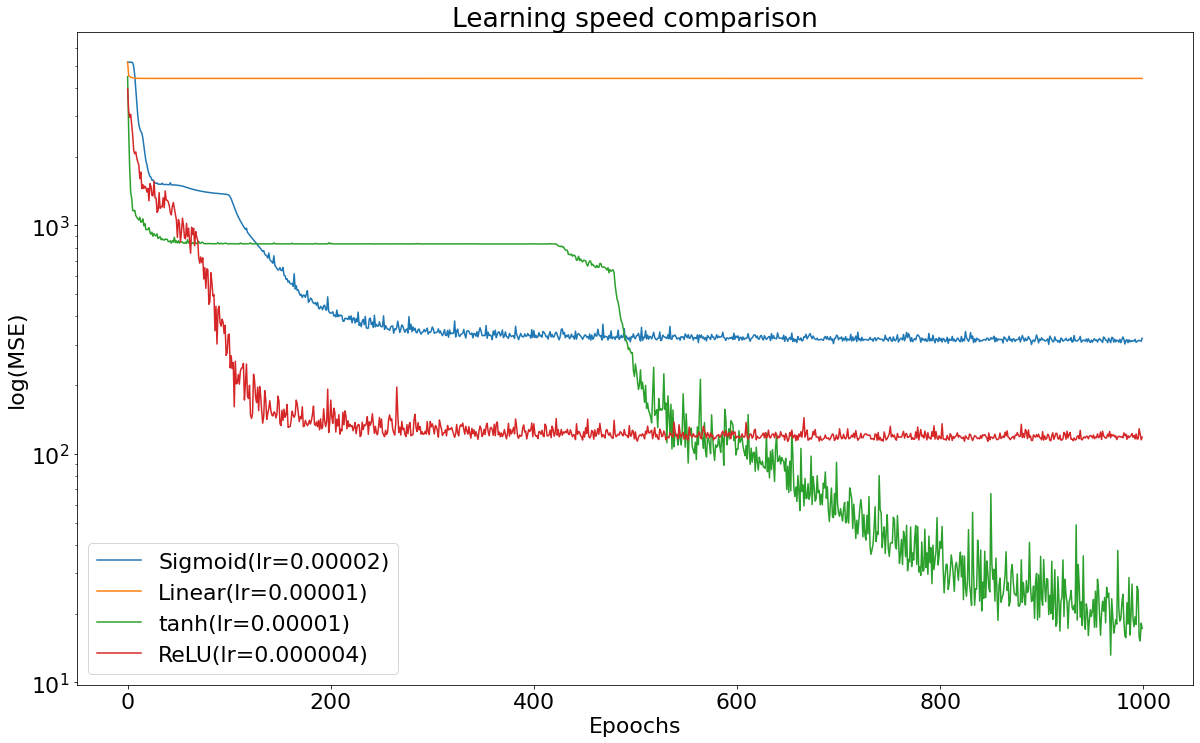

In [33]:
plt.figure(figsize=(20,12))
plt.rcParams.update({'font.size': 22})
plt.plot(lossesSigmoid2,label="Sigmoid(lr=0.00002)")
plt.plot(lossesLinear2,label="Linear(lr=0.00001)")
plt.plot(lossestanh2,label="tanh(lr=0.00001)")
plt.plot(lossesRelu2,label="ReLU(lr=0.000004)")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()

## 3 hidden layers

### Sigmoid

In [78]:
nn = NeuralNetwork(1,[10,10,10,1],["sigmoid","sigmoid","sigmoid","linear"],["uniform","uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.00003)

In [79]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 5189.920882509167
Epoch 2/1000 - loss: 5180.92292890003
Epoch 3/1000 - loss: 5179.269643189535
Epoch 4/1000 - loss: 5178.681227291941
Epoch 5/1000 - loss: 5180.275619151836
Epoch 6/1000 - loss: 5179.656318451379
Epoch 7/1000 - loss: 5178.357027338927
Epoch 8/1000 - loss: 5179.598528864446
Epoch 9/1000 - loss: 5178.438735946077
Epoch 10/1000 - loss: 5180.146287972744
Epoch 11/1000 - loss: 5180.020072841449
Epoch 12/1000 - loss: 5178.2480816958605
Epoch 13/1000 - loss: 5179.6632462331
Epoch 14/1000 - loss: 5179.046603415185
Epoch 15/1000 - loss: 5176.0656249779395
Epoch 16/1000 - loss: 5161.883727787753
Epoch 17/1000 - loss: 4704.190692043435
Epoch 18/1000 - loss: 3332.5359099553352
Epoch 19/1000 - loss: 2813.7185648480363
Epoch 20/1000 - loss: 2637.2021386300644
Epoch 21/1000 - loss: 2589.418262116851
Epoch 22/1000 - loss: 2544.0498987406204
Epoch 23/1000 - loss: 2566.749859840165
Epoch 24/1000 - loss: 2527.3770642945406
Epoch 25/1000 - loss: 2528.976969331847
Epoch

Epoch 201/1000 - loss: 1504.2614282134168
Epoch 202/1000 - loss: 1503.7588473890278
Epoch 203/1000 - loss: 1506.9609473585074
Epoch 204/1000 - loss: 1506.8951121313328
Epoch 205/1000 - loss: 1503.452095891904
Epoch 206/1000 - loss: 1503.3899217573057
Epoch 207/1000 - loss: 1503.707065355167
Epoch 208/1000 - loss: 1503.8189651928394
Epoch 209/1000 - loss: 1504.640987901595
Epoch 210/1000 - loss: 1503.3537716648073
Epoch 211/1000 - loss: 1503.2982267070217
Epoch 212/1000 - loss: 1503.8661366311844
Epoch 213/1000 - loss: 1503.7659077078902
Epoch 214/1000 - loss: 1505.7559357844887
Epoch 215/1000 - loss: 1503.707618386812
Epoch 216/1000 - loss: 1504.1875722388857
Epoch 217/1000 - loss: 1503.912631431441
Epoch 218/1000 - loss: 1503.7132679018716
Epoch 219/1000 - loss: 1503.489894806794
Epoch 220/1000 - loss: 1503.3497468140647
Epoch 221/1000 - loss: 1503.3807888645865
Epoch 222/1000 - loss: 1503.3029999069158
Epoch 223/1000 - loss: 1503.615650053894
Epoch 224/1000 - loss: 1504.0656370922886

Epoch 398/1000 - loss: 1502.3718928918474
Epoch 399/1000 - loss: 1502.3431080025068
Epoch 400/1000 - loss: 1502.7194665527034
Epoch 401/1000 - loss: 1502.5416303329448
Epoch 402/1000 - loss: 1502.5600953709006
Epoch 403/1000 - loss: 1502.2883786142936
Epoch 404/1000 - loss: 1502.300346987206
Epoch 405/1000 - loss: 1502.2452267043639
Epoch 406/1000 - loss: 1502.1253060454694
Epoch 407/1000 - loss: 1503.6648580379947
Epoch 408/1000 - loss: 1503.5073347901964
Epoch 409/1000 - loss: 1502.1327280956505
Epoch 410/1000 - loss: 1502.4343328153238
Epoch 411/1000 - loss: 1502.508817523615
Epoch 412/1000 - loss: 1502.2104560679313
Epoch 413/1000 - loss: 1502.3822229008977
Epoch 414/1000 - loss: 1502.2668702440235
Epoch 415/1000 - loss: 1502.327066582116
Epoch 416/1000 - loss: 1502.3382657059751
Epoch 417/1000 - loss: 1502.1736409204507
Epoch 418/1000 - loss: 1502.23896397283
Epoch 419/1000 - loss: 1502.5476264045342
Epoch 420/1000 - loss: 1502.6436141617894
Epoch 421/1000 - loss: 1502.06659723610

Epoch 595/1000 - loss: 553.0493016845453
Epoch 596/1000 - loss: 551.6627966382167
Epoch 597/1000 - loss: 536.0621671330324
Epoch 598/1000 - loss: 543.3345465683335
Epoch 599/1000 - loss: 498.19424791788475
Epoch 600/1000 - loss: 504.4461656643936
Epoch 601/1000 - loss: 512.29554922078
Epoch 602/1000 - loss: 524.383205783698
Epoch 603/1000 - loss: 536.0137019388955
Epoch 604/1000 - loss: 462.68431940714606
Epoch 605/1000 - loss: 484.5280077600305
Epoch 606/1000 - loss: 464.7209994367405
Epoch 607/1000 - loss: 487.70996147713345
Epoch 608/1000 - loss: 445.3758104299322
Epoch 609/1000 - loss: 488.6836874053131
Epoch 610/1000 - loss: 458.1837938316508
Epoch 611/1000 - loss: 499.1845440556411
Epoch 612/1000 - loss: 461.1889269906138
Epoch 613/1000 - loss: 452.08954928667293
Epoch 614/1000 - loss: 431.7116593559609
Epoch 615/1000 - loss: 444.3375343351556
Epoch 616/1000 - loss: 460.9882409723566
Epoch 617/1000 - loss: 420.8111353918118
Epoch 618/1000 - loss: 437.86600218834894
Epoch 619/1000

Epoch 794/1000 - loss: 356.8660318726393
Epoch 795/1000 - loss: 371.26141569397936
Epoch 796/1000 - loss: 355.8418458921606
Epoch 797/1000 - loss: 357.0344171359484
Epoch 798/1000 - loss: 358.74512051959067
Epoch 799/1000 - loss: 364.26394978747123
Epoch 800/1000 - loss: 355.9452872951559
Epoch 801/1000 - loss: 355.77198872740445
Epoch 802/1000 - loss: 357.5935627996856
Epoch 803/1000 - loss: 376.4148999645311
Epoch 804/1000 - loss: 361.50642702958646
Epoch 805/1000 - loss: 358.2192869620494
Epoch 806/1000 - loss: 363.2994692938195
Epoch 807/1000 - loss: 365.20764132816373
Epoch 808/1000 - loss: 378.43582668840713
Epoch 809/1000 - loss: 356.51400665265777
Epoch 810/1000 - loss: 355.9476904105815
Epoch 811/1000 - loss: 392.55650597423954
Epoch 812/1000 - loss: 358.83455374444543
Epoch 813/1000 - loss: 360.16841092140135
Epoch 814/1000 - loss: 359.5314954392132
Epoch 815/1000 - loss: 354.608300125863
Epoch 816/1000 - loss: 358.34229360570566
Epoch 817/1000 - loss: 362.9433151976394
Epoch

Epoch 993/1000 - loss: 355.27694270549694
Epoch 994/1000 - loss: 354.9000434098427
Epoch 995/1000 - loss: 358.60479202719284
Epoch 996/1000 - loss: 372.0085147580998
Epoch 997/1000 - loss: 353.9116346977808
Epoch 998/1000 - loss: 370.11591021886164
Epoch 999/1000 - loss: 369.3933029069187
Epoch 1000/1000 - loss: 355.47191652376335


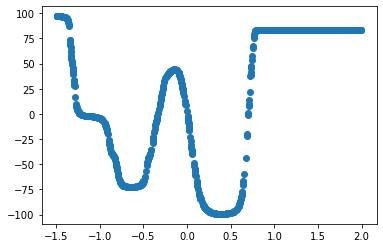

In [80]:
lossesSigmoid3 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [81]:
MSE(y_pred.flatten(), Y_test)

397.10222842955307

### Linear

In [82]:
nn = NeuralNetwork(1,[10,10,10,1],["linear","linear","linear","linear"],["uniform","uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.000001)

In [83]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 4571.386570671465
Epoch 2/1000 - loss: 4415.224670599703
Epoch 3/1000 - loss: 4415.989027928456
Epoch 4/1000 - loss: 4411.594717687707
Epoch 5/1000 - loss: 4413.174500838263
Epoch 6/1000 - loss: 4408.034103042137
Epoch 7/1000 - loss: 4405.031996770681
Epoch 8/1000 - loss: 4408.05492960928
Epoch 9/1000 - loss: 4412.456584423674
Epoch 10/1000 - loss: 4414.537738676794
Epoch 11/1000 - loss: 4407.74370305829
Epoch 12/1000 - loss: 4405.934859455775
Epoch 13/1000 - loss: 4417.086519645656
Epoch 14/1000 - loss: 4414.2496467899655
Epoch 15/1000 - loss: 4409.974569914667
Epoch 16/1000 - loss: 4405.830390464431
Epoch 17/1000 - loss: 4413.014010692613
Epoch 18/1000 - loss: 4412.961848080235
Epoch 19/1000 - loss: 4409.989269602663
Epoch 20/1000 - loss: 4407.754329477311
Epoch 21/1000 - loss: 4407.351500254869
Epoch 22/1000 - loss: 4408.65944323152
Epoch 23/1000 - loss: 4411.37481127469
Epoch 24/1000 - loss: 4409.5771642080035
Epoch 25/1000 - loss: 4405.174300012117
Epoch 26/10

Epoch 204/1000 - loss: 4404.172362900119
Epoch 205/1000 - loss: 4403.572927731233
Epoch 206/1000 - loss: 4406.505745014656
Epoch 207/1000 - loss: 4403.801234335513
Epoch 208/1000 - loss: 4401.814636766748
Epoch 209/1000 - loss: 4403.131734455528
Epoch 210/1000 - loss: 4406.184450902267
Epoch 211/1000 - loss: 4402.799905153846
Epoch 212/1000 - loss: 4403.461876366022
Epoch 213/1000 - loss: 4403.561402965066
Epoch 214/1000 - loss: 4403.826144742608
Epoch 215/1000 - loss: 4404.258120700385
Epoch 216/1000 - loss: 4403.711547638599
Epoch 217/1000 - loss: 4403.584137082084
Epoch 218/1000 - loss: 4405.106598608178
Epoch 219/1000 - loss: 4402.654260555829
Epoch 220/1000 - loss: 4400.896416707586
Epoch 221/1000 - loss: 4405.284494693877
Epoch 222/1000 - loss: 4404.479611814199
Epoch 223/1000 - loss: 4404.688814247809
Epoch 224/1000 - loss: 4404.2830762830745
Epoch 225/1000 - loss: 4403.025178574731
Epoch 226/1000 - loss: 4405.842372384979
Epoch 227/1000 - loss: 4406.709835246793
Epoch 228/1000 

Epoch 404/1000 - loss: 4401.844841034502
Epoch 405/1000 - loss: 4402.43735415825
Epoch 406/1000 - loss: 4404.661726352363
Epoch 407/1000 - loss: 4405.249960340361
Epoch 408/1000 - loss: 4402.470697338032
Epoch 409/1000 - loss: 4401.60392732046
Epoch 410/1000 - loss: 4402.026797753157
Epoch 411/1000 - loss: 4402.730976161343
Epoch 412/1000 - loss: 4403.468521375578
Epoch 413/1000 - loss: 4401.001934195634
Epoch 414/1000 - loss: 4405.521557276769
Epoch 415/1000 - loss: 4402.280467471303
Epoch 416/1000 - loss: 4403.149481066823
Epoch 417/1000 - loss: 4401.950285231211
Epoch 418/1000 - loss: 4400.952709144882
Epoch 419/1000 - loss: 4401.747836442452
Epoch 420/1000 - loss: 4400.14626519376
Epoch 421/1000 - loss: 4404.103628745091
Epoch 422/1000 - loss: 4399.680197592748
Epoch 423/1000 - loss: 4403.387792927697
Epoch 424/1000 - loss: 4404.442742868397
Epoch 425/1000 - loss: 4403.063549214169
Epoch 426/1000 - loss: 4403.205354521838
Epoch 427/1000 - loss: 4405.791304444595
Epoch 428/1000 - lo

Epoch 605/1000 - loss: 4403.554502660147
Epoch 606/1000 - loss: 4402.635785719898
Epoch 607/1000 - loss: 4402.153521618809
Epoch 608/1000 - loss: 4401.71273051013
Epoch 609/1000 - loss: 4402.379172521366
Epoch 610/1000 - loss: 4402.60912431093
Epoch 611/1000 - loss: 4403.767684208361
Epoch 612/1000 - loss: 4401.774178888606
Epoch 613/1000 - loss: 4399.773923369394
Epoch 614/1000 - loss: 4402.370949402856
Epoch 615/1000 - loss: 4401.322092788519
Epoch 616/1000 - loss: 4402.037528049083
Epoch 617/1000 - loss: 4401.76381312705
Epoch 618/1000 - loss: 4401.899178139716
Epoch 619/1000 - loss: 4403.764099743024
Epoch 620/1000 - loss: 4401.205713646367
Epoch 621/1000 - loss: 4403.556491219281
Epoch 622/1000 - loss: 4400.326574325428
Epoch 623/1000 - loss: 4399.046309414937
Epoch 624/1000 - loss: 4402.289453276089
Epoch 625/1000 - loss: 4403.078147364012
Epoch 626/1000 - loss: 4402.874089116359
Epoch 627/1000 - loss: 4404.086454219745
Epoch 628/1000 - loss: 4401.955061311076
Epoch 629/1000 - lo

Epoch 806/1000 - loss: 4402.080725408359
Epoch 807/1000 - loss: 4403.379844741957
Epoch 808/1000 - loss: 4400.392950872489
Epoch 809/1000 - loss: 4403.806572653617
Epoch 810/1000 - loss: 4401.970073544592
Epoch 811/1000 - loss: 4401.893276427441
Epoch 812/1000 - loss: 4402.600053757849
Epoch 813/1000 - loss: 4401.420022401059
Epoch 814/1000 - loss: 4402.831894022608
Epoch 815/1000 - loss: 4401.4150195513785
Epoch 816/1000 - loss: 4400.366880458485
Epoch 817/1000 - loss: 4402.437274054217
Epoch 818/1000 - loss: 4400.7719365307685
Epoch 819/1000 - loss: 4401.688667722026
Epoch 820/1000 - loss: 4401.825670717915
Epoch 821/1000 - loss: 4403.260784925976
Epoch 822/1000 - loss: 4400.283314819885
Epoch 823/1000 - loss: 4401.831847825272
Epoch 824/1000 - loss: 4402.709158602154
Epoch 825/1000 - loss: 4404.083499305149
Epoch 826/1000 - loss: 4401.577610305446
Epoch 827/1000 - loss: 4401.465938401143
Epoch 828/1000 - loss: 4402.36656864666
Epoch 829/1000 - loss: 4401.526178999339
Epoch 830/1000 

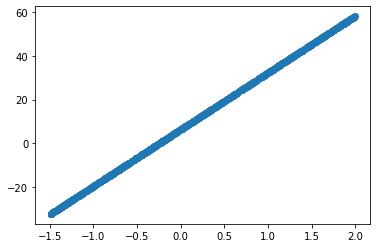

In [84]:
lossesLinear3 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [85]:
MSE(y_pred.flatten(), Y_test)

4438.647974223144

### tanh

In [135]:
nn = NeuralNetwork(1,[10,10,10,1],["tanh","tanh","tanh","linear"],["uniform","uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.000001)

In [136]:
nn.fit(X_train_std.copy(), Y_train_std.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 7.159633115188031
Epoch 2/1000 - loss: 4.650850240440353
Epoch 3/1000 - loss: 3.037596364815362
Epoch 4/1000 - loss: 1.9999797948873195
Epoch 5/1000 - loss: 1.3326045555507016
Epoch 6/1000 - loss: 0.9035030134087707
Epoch 7/1000 - loss: 0.627625846841217
Epoch 8/1000 - loss: 0.4501790744835449
Epoch 9/1000 - loss: 0.336017740508122
Epoch 10/1000 - loss: 0.26262597329819504
Epoch 11/1000 - loss: 0.21542038937105093
Epoch 12/1000 - loss: 0.18505420417471966
Epoch 13/1000 - loss: 0.16552051020999956
Epoch 14/1000 - loss: 0.15297276242957536
Epoch 15/1000 - loss: 0.14490109756282246
Epoch 16/1000 - loss: 0.13970116332377974
Epoch 17/1000 - loss: 0.13635637134149098
Epoch 18/1000 - loss: 0.1342194131375067
Epoch 19/1000 - loss: 0.13284421112202555
Epoch 20/1000 - loss: 0.1319606514915569
Epoch 21/1000 - loss: 0.13138789879156362
Epoch 22/1000 - loss: 0.13102118029656623
Epoch 23/1000 - loss: 0.1307850887213758
Epoch 24/1000 - loss: 0.13063099156079816
Epoch 25/1000 - lo

Epoch 196/1000 - loss: 0.1303550623508447
Epoch 197/1000 - loss: 0.1303543425415854
Epoch 198/1000 - loss: 0.1303552045121721
Epoch 199/1000 - loss: 0.13035571295564952
Epoch 200/1000 - loss: 0.13035471460766743
Epoch 201/1000 - loss: 0.13035497984383718
Epoch 202/1000 - loss: 0.13035476530517004
Epoch 203/1000 - loss: 0.13035596483060918
Epoch 204/1000 - loss: 0.13035563877378167
Epoch 205/1000 - loss: 0.1303563506394999
Epoch 206/1000 - loss: 0.13035501322800186
Epoch 207/1000 - loss: 0.13035638311380326
Epoch 208/1000 - loss: 0.13035482907065052
Epoch 209/1000 - loss: 0.13035625369751558
Epoch 210/1000 - loss: 0.13035533871858157
Epoch 211/1000 - loss: 0.1303545468519557
Epoch 212/1000 - loss: 0.130355066180213
Epoch 213/1000 - loss: 0.1303551310339249
Epoch 214/1000 - loss: 0.1303547897131024
Epoch 215/1000 - loss: 0.1303551426754284
Epoch 216/1000 - loss: 0.1303555344333251
Epoch 217/1000 - loss: 0.13035474562182367
Epoch 218/1000 - loss: 0.1303566255851097
Epoch 219/1000 - loss: 

Epoch 389/1000 - loss: 0.13035535955409613
Epoch 390/1000 - loss: 0.1303552534324557
Epoch 391/1000 - loss: 0.13035360418213363
Epoch 392/1000 - loss: 0.13035393739081705
Epoch 393/1000 - loss: 0.1303559324044454
Epoch 394/1000 - loss: 0.13035461167381868
Epoch 395/1000 - loss: 0.13035448671315703
Epoch 396/1000 - loss: 0.13035443702884805
Epoch 397/1000 - loss: 0.1303547274605191
Epoch 398/1000 - loss: 0.1303546092531256
Epoch 399/1000 - loss: 0.13035454101598634
Epoch 400/1000 - loss: 0.13035616337239567
Epoch 401/1000 - loss: 0.1303553158083282
Epoch 402/1000 - loss: 0.13035516337773928
Epoch 403/1000 - loss: 0.13035543007202643
Epoch 404/1000 - loss: 0.13035462409592866
Epoch 405/1000 - loss: 0.1303546252514746
Epoch 406/1000 - loss: 0.13035440166322695
Epoch 407/1000 - loss: 0.13035693528552691
Epoch 408/1000 - loss: 0.13035620735687112
Epoch 409/1000 - loss: 0.130354542574077
Epoch 410/1000 - loss: 0.13035496648515002
Epoch 411/1000 - loss: 0.13035525429765457
Epoch 412/1000 - lo

Epoch 581/1000 - loss: 0.1303547189292991
Epoch 582/1000 - loss: 0.1303533586866282
Epoch 583/1000 - loss: 0.13035461321040076
Epoch 584/1000 - loss: 0.13035460327622522
Epoch 585/1000 - loss: 0.13035476739657192
Epoch 586/1000 - loss: 0.13035398079781144
Epoch 587/1000 - loss: 0.13035355773195856
Epoch 588/1000 - loss: 0.13035438979569547
Epoch 589/1000 - loss: 0.1303543426068073
Epoch 590/1000 - loss: 0.13035418684783318
Epoch 591/1000 - loss: 0.13035634755176356
Epoch 592/1000 - loss: 0.13035467868498557
Epoch 593/1000 - loss: 0.1303553952549217
Epoch 594/1000 - loss: 0.13035445831574646
Epoch 595/1000 - loss: 0.1303540982435862
Epoch 596/1000 - loss: 0.13035527128009264
Epoch 597/1000 - loss: 0.13035452032421294
Epoch 598/1000 - loss: 0.13035413534289708
Epoch 599/1000 - loss: 0.13035374930858448
Epoch 600/1000 - loss: 0.1303544471995221
Epoch 601/1000 - loss: 0.130354097758469
Epoch 602/1000 - loss: 0.13035432996006452
Epoch 603/1000 - loss: 0.1303540806201568
Epoch 604/1000 - los

Epoch 774/1000 - loss: 0.13035446568924855
Epoch 775/1000 - loss: 0.1303546759819578
Epoch 776/1000 - loss: 0.13035350147910138
Epoch 777/1000 - loss: 0.13035449444488162
Epoch 778/1000 - loss: 0.1303544004312042
Epoch 779/1000 - loss: 0.13035315977824638
Epoch 780/1000 - loss: 0.13035348121270293
Epoch 781/1000 - loss: 0.1303537725524075
Epoch 782/1000 - loss: 0.130354499829248
Epoch 783/1000 - loss: 0.13035475573521543
Epoch 784/1000 - loss: 0.13035492254044215
Epoch 785/1000 - loss: 0.13035385660106225
Epoch 786/1000 - loss: 0.1303534749689026
Epoch 787/1000 - loss: 0.13035460857730125
Epoch 788/1000 - loss: 0.13035453305871603
Epoch 789/1000 - loss: 0.13035491748891095
Epoch 790/1000 - loss: 0.13035461989406263
Epoch 791/1000 - loss: 0.1303549718478396
Epoch 792/1000 - loss: 0.1303530380309353
Epoch 793/1000 - loss: 0.13035434832709053
Epoch 794/1000 - loss: 0.13035286920309597
Epoch 795/1000 - loss: 0.13035421671073363
Epoch 796/1000 - loss: 0.1303540843788654
Epoch 797/1000 - los

Epoch 966/1000 - loss: 0.13035407183998285
Epoch 967/1000 - loss: 0.1303534070472433
Epoch 968/1000 - loss: 0.1303540790880421
Epoch 969/1000 - loss: 0.1303545394443009
Epoch 970/1000 - loss: 0.13035429419984224
Epoch 971/1000 - loss: 0.13035416991218
Epoch 972/1000 - loss: 0.13035402428778498
Epoch 973/1000 - loss: 0.1303536926794568
Epoch 974/1000 - loss: 0.13035303727852035
Epoch 975/1000 - loss: 0.13035361373470358
Epoch 976/1000 - loss: 0.13035343083298345
Epoch 977/1000 - loss: 0.1303537322384571
Epoch 978/1000 - loss: 0.13035369679535352
Epoch 979/1000 - loss: 0.13035369533039234
Epoch 980/1000 - loss: 0.1303526991203978
Epoch 981/1000 - loss: 0.13035435072944296
Epoch 982/1000 - loss: 0.1303542478155841
Epoch 983/1000 - loss: 0.1303536160882395
Epoch 984/1000 - loss: 0.1303544610205499
Epoch 985/1000 - loss: 0.1303547134125822
Epoch 986/1000 - loss: 0.13035283604026085
Epoch 987/1000 - loss: 0.13035453274156455
Epoch 988/1000 - loss: 0.130353765382459
Epoch 989/1000 - loss: 0.1

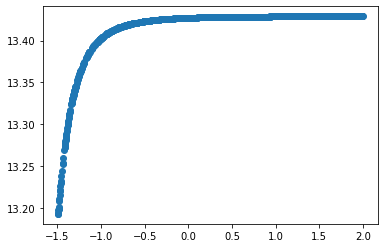

In [137]:
lossestanh3 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = scalery.inverse_transform(y_pred.reshape(-1,1))
plt.scatter(X_test, y_pred)
plt.show()

In [138]:
MSE(y_pred.flatten(), Y_test)

5222.616060216584

### ReLU

In [115]:
nn = NeuralNetwork(1,[10,10,10,1],["relu","relu","relu","linear"],["uniform","uniform","uniform","uniform"])
nn.compile(loss = "MSE", optimizer= "BGD", lr = 0.000001)

In [116]:
nn.fit(X_train_std.copy(), Y_train_std.copy(), epochs = 1000, batch_size = 32)

Epoch 1/1000 - loss: 206.599170716271
Epoch 2/1000 - loss: 0.102712471877142
Epoch 3/1000 - loss: 0.10215039257734472
Epoch 4/1000 - loss: 0.1019794815714921
Epoch 5/1000 - loss: 0.10181784662560724
Epoch 6/1000 - loss: 0.10165160255941148
Epoch 7/1000 - loss: 0.10147923580500838
Epoch 8/1000 - loss: 0.10132448727452213
Epoch 9/1000 - loss: 0.10117069795865953
Epoch 10/1000 - loss: 0.10102652641139487
Epoch 11/1000 - loss: 0.1008631772629296
Epoch 12/1000 - loss: 0.10071351088149563
Epoch 13/1000 - loss: 0.100569617084331
Epoch 14/1000 - loss: 0.10042793823268975
Epoch 15/1000 - loss: 0.10027221517032409
Epoch 16/1000 - loss: 0.10011295866484111
Epoch 17/1000 - loss: 0.09997439099699973
Epoch 18/1000 - loss: 0.09982984679526151
Epoch 19/1000 - loss: 0.09969458410811288
Epoch 20/1000 - loss: 0.09952825037128578
Epoch 21/1000 - loss: 0.09941810436838845
Epoch 22/1000 - loss: 0.09927280258609766
Epoch 23/1000 - loss: 0.09915517072342496
Epoch 24/1000 - loss: 0.09900505440214626
Epoch 25/1

Epoch 195/1000 - loss: 0.08566253232735946
Epoch 196/1000 - loss: 0.08558893831161854
Epoch 197/1000 - loss: 0.08555865373955279
Epoch 198/1000 - loss: 0.08551687244238579
Epoch 199/1000 - loss: 0.08547978835637518
Epoch 200/1000 - loss: 0.08543080438997525
Epoch 201/1000 - loss: 0.08538869728863546
Epoch 202/1000 - loss: 0.08532305951024673
Epoch 203/1000 - loss: 0.08529518058382399
Epoch 204/1000 - loss: 0.08525096360494062
Epoch 205/1000 - loss: 0.08521803534291442
Epoch 206/1000 - loss: 0.08516062872826777
Epoch 207/1000 - loss: 0.08513804692903064
Epoch 208/1000 - loss: 0.08507030783966078
Epoch 209/1000 - loss: 0.08504603313503738
Epoch 210/1000 - loss: 0.0849937945654445
Epoch 211/1000 - loss: 0.08494261700058071
Epoch 212/1000 - loss: 0.08489772554309091
Epoch 213/1000 - loss: 0.08486953812009843
Epoch 214/1000 - loss: 0.08482051694522114
Epoch 215/1000 - loss: 0.08478498482017967
Epoch 216/1000 - loss: 0.08474848897066586
Epoch 217/1000 - loss: 0.08468486000819431
Epoch 218/10

Epoch 387/1000 - loss: 0.07789474502658862
Epoch 388/1000 - loss: 0.07783580022669509
Epoch 389/1000 - loss: 0.07783927466539564
Epoch 390/1000 - loss: 0.07778941256250523
Epoch 391/1000 - loss: 0.07773268779801316
Epoch 392/1000 - loss: 0.07770968066262815
Epoch 393/1000 - loss: 0.0776828172060841
Epoch 394/1000 - loss: 0.07763801368854745
Epoch 395/1000 - loss: 0.07758893216341543
Epoch 396/1000 - loss: 0.07752051484372757
Epoch 397/1000 - loss: 0.07753047394558181
Epoch 398/1000 - loss: 0.07748783814194642
Epoch 399/1000 - loss: 0.07745277161519276
Epoch 400/1000 - loss: 0.07743203206849399
Epoch 401/1000 - loss: 0.07739672169598287
Epoch 402/1000 - loss: 0.0773425998872556
Epoch 403/1000 - loss: 0.07730536971680226
Epoch 404/1000 - loss: 0.07727069908758039
Epoch 405/1000 - loss: 0.07724081467390571
Epoch 406/1000 - loss: 0.07720678920287259
Epoch 407/1000 - loss: 0.07717923049572162
Epoch 408/1000 - loss: 0.07714942616961491
Epoch 409/1000 - loss: 0.07708807304624374
Epoch 410/100

Epoch 579/1000 - loss: 0.07194414310985518
Epoch 580/1000 - loss: 0.07191471266782627
Epoch 581/1000 - loss: 0.07190781689590223
Epoch 582/1000 - loss: 0.07185881502212302
Epoch 583/1000 - loss: 0.07182551167706351
Epoch 584/1000 - loss: 0.07181968264323035
Epoch 585/1000 - loss: 0.0717751397317186
Epoch 586/1000 - loss: 0.07175171930350766
Epoch 587/1000 - loss: 0.07173193524185272
Epoch 588/1000 - loss: 0.07171767669342984
Epoch 589/1000 - loss: 0.07169065764632854
Epoch 590/1000 - loss: 0.07166397478496081
Epoch 591/1000 - loss: 0.07165059687789033
Epoch 592/1000 - loss: 0.07162203653717557
Epoch 593/1000 - loss: 0.07158141556926163
Epoch 594/1000 - loss: 0.07156078802792301
Epoch 595/1000 - loss: 0.07154146441538912
Epoch 596/1000 - loss: 0.07152013888250221
Epoch 597/1000 - loss: 0.07148961302388479
Epoch 598/1000 - loss: 0.07145934469520296
Epoch 599/1000 - loss: 0.0714396554193139
Epoch 600/1000 - loss: 0.07139811671461402
Epoch 601/1000 - loss: 0.07139066642952446
Epoch 602/100

Epoch 771/1000 - loss: 0.06791076740404024
Epoch 772/1000 - loss: 0.06791632795014078
Epoch 773/1000 - loss: 0.06788357564827002
Epoch 774/1000 - loss: 0.06787023640968239
Epoch 775/1000 - loss: 0.06787411075213304
Epoch 776/1000 - loss: 0.06783575853489802
Epoch 777/1000 - loss: 0.06783846299178255
Epoch 778/1000 - loss: 0.0678235106752069
Epoch 779/1000 - loss: 0.06781526550576669
Epoch 780/1000 - loss: 0.06780142179746043
Epoch 781/1000 - loss: 0.06779154830745925
Epoch 782/1000 - loss: 0.0677873204035121
Epoch 783/1000 - loss: 0.06778709409964297
Epoch 784/1000 - loss: 0.0677660483813567
Epoch 785/1000 - loss: 0.06774366043996419
Epoch 786/1000 - loss: 0.06772983776401209
Epoch 787/1000 - loss: 0.0677177054201811
Epoch 788/1000 - loss: 0.06771978578527903
Epoch 789/1000 - loss: 0.06771486003274627
Epoch 790/1000 - loss: 0.06769103779501003
Epoch 791/1000 - loss: 0.06768503262573161
Epoch 792/1000 - loss: 0.06765587683122262
Epoch 793/1000 - loss: 0.06765135525164455
Epoch 794/1000 

Epoch 963/1000 - loss: 0.06662573410734837
Epoch 964/1000 - loss: 0.06659900196275817
Epoch 965/1000 - loss: 0.06660215501130874
Epoch 966/1000 - loss: 0.06660302790810227
Epoch 967/1000 - loss: 0.06659606266114186
Epoch 968/1000 - loss: 0.06660005166598297
Epoch 969/1000 - loss: 0.06658301087959649
Epoch 970/1000 - loss: 0.06658615791062093
Epoch 971/1000 - loss: 0.06660071076010658
Epoch 972/1000 - loss: 0.06658198337577165
Epoch 973/1000 - loss: 0.06657566999576281
Epoch 974/1000 - loss: 0.06656856400679702
Epoch 975/1000 - loss: 0.06657465710463792
Epoch 976/1000 - loss: 0.06656340554771781
Epoch 977/1000 - loss: 0.06655565045398218
Epoch 978/1000 - loss: 0.06655990987715794
Epoch 979/1000 - loss: 0.0665685360047195
Epoch 980/1000 - loss: 0.06654775069792046
Epoch 981/1000 - loss: 0.06655956029635725
Epoch 982/1000 - loss: 0.06654589886319713
Epoch 983/1000 - loss: 0.06656488449415163
Epoch 984/1000 - loss: 0.06655407325242609
Epoch 985/1000 - loss: 0.06654204303397367
Epoch 986/10

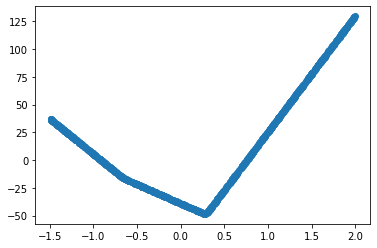

In [119]:
lossesRelu3 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = scalery.inverse_transform(y_pred.reshape(-1,1))
plt.scatter(X_test, y_pred)
plt.show()

In [120]:
MSE(y_pred.flatten(), Y_test)

2641.5812222622576

# steps-large

In [3]:
train_df = pd.read_csv("data/steps-large-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/steps-large-test.csv",index_col=0).reset_index()

In [55]:
X_train = np.reshape(train_df["x"].values,(len(train_df),1))
Y_train = np.reshape(train_df["y"].values,(len(train_df),1))

In [56]:
X_test = np.reshape(test_df["x"].values,(len(test_df),1))
Y_test = np.reshape(test_df["y"].values,(len(test_df),1))

#### Normalize the data

In [57]:
scalerx = StandardScaler()
X_train_std = scalerx.fit_transform(X_train)
X_test_std = scalerx.transform(X_test)

### Sigmoid

In [130]:
nn = NeuralNetwork(1,[32,32,1],["sigmoid","sigmoid","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "BGD", lr = 0.00001)

In [131]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size=32)

Epoch 1/1000 - loss: 6835.570383871254
Epoch 2/1000 - loss: 6833.091454324901
Epoch 3/1000 - loss: 6830.984153883898
Epoch 4/1000 - loss: 6832.704518374865
Epoch 5/1000 - loss: 6829.514327101216
Epoch 6/1000 - loss: 6831.81496562869
Epoch 7/1000 - loss: 6829.274109490976
Epoch 8/1000 - loss: 6827.4298451910945
Epoch 9/1000 - loss: 6823.2840069210115
Epoch 10/1000 - loss: 6751.900788685167
Epoch 11/1000 - loss: 5781.716939279846
Epoch 12/1000 - loss: 3417.9915561567454
Epoch 13/1000 - loss: 1983.7617532509546
Epoch 14/1000 - loss: 1453.9176836068705
Epoch 15/1000 - loss: 1184.303806262252
Epoch 16/1000 - loss: 963.9285690441181
Epoch 17/1000 - loss: 781.3254140839595
Epoch 18/1000 - loss: 638.3967977890185
Epoch 19/1000 - loss: 523.9116059307531
Epoch 20/1000 - loss: 434.2744205966428
Epoch 21/1000 - loss: 376.6359343940066
Epoch 22/1000 - loss: 322.47902936153037
Epoch 23/1000 - loss: 284.5113569348285
Epoch 24/1000 - loss: 267.9049873964092
Epoch 25/1000 - loss: 244.7561249847046
Epoc

Epoch 203/1000 - loss: 39.7414929442184
Epoch 204/1000 - loss: 39.88581145150153
Epoch 205/1000 - loss: 40.90998422460628
Epoch 206/1000 - loss: 39.75323764501987
Epoch 207/1000 - loss: 38.9925963359119
Epoch 208/1000 - loss: 38.05548425721972
Epoch 209/1000 - loss: 38.49667175492529
Epoch 210/1000 - loss: 38.67572570049673
Epoch 211/1000 - loss: 38.923073542177995
Epoch 212/1000 - loss: 41.36159048429993
Epoch 213/1000 - loss: 40.54076138767252
Epoch 214/1000 - loss: 37.77885786299348
Epoch 215/1000 - loss: 37.47027386978721
Epoch 216/1000 - loss: 39.16185516390507
Epoch 217/1000 - loss: 39.2041827534173
Epoch 218/1000 - loss: 40.1659621755454
Epoch 219/1000 - loss: 39.406028026091775
Epoch 220/1000 - loss: 40.187180701610785
Epoch 221/1000 - loss: 39.87593957129242
Epoch 222/1000 - loss: 38.3806705158703
Epoch 223/1000 - loss: 38.552852047631596
Epoch 224/1000 - loss: 38.14672953887922
Epoch 225/1000 - loss: 39.601298773961524
Epoch 226/1000 - loss: 38.79828527339212
Epoch 227/1000 -

Epoch 401/1000 - loss: 28.990165564802727
Epoch 402/1000 - loss: 25.820359685924604
Epoch 403/1000 - loss: 27.200279778715053
Epoch 404/1000 - loss: 26.686310580855988
Epoch 405/1000 - loss: 26.298924804446987
Epoch 406/1000 - loss: 28.305986471987516
Epoch 407/1000 - loss: 27.096676328595215
Epoch 408/1000 - loss: 27.433691514567762
Epoch 409/1000 - loss: 28.02667131871516
Epoch 410/1000 - loss: 28.886807961076673
Epoch 411/1000 - loss: 28.655007866975154
Epoch 412/1000 - loss: 25.70092525370281
Epoch 413/1000 - loss: 26.605169755987603
Epoch 414/1000 - loss: 27.003100980275548
Epoch 415/1000 - loss: 26.797797582098223
Epoch 416/1000 - loss: 27.853489884002094
Epoch 417/1000 - loss: 26.62326093787669
Epoch 418/1000 - loss: 28.185333264923653
Epoch 419/1000 - loss: 28.599835628674576
Epoch 420/1000 - loss: 27.936199041700213
Epoch 421/1000 - loss: 28.38617279464136
Epoch 422/1000 - loss: 27.841621834481426
Epoch 423/1000 - loss: 28.477720593232696
Epoch 424/1000 - loss: 26.089945882598

Epoch 598/1000 - loss: 23.216759710562428
Epoch 599/1000 - loss: 24.517071693309973
Epoch 600/1000 - loss: 23.462832013619774
Epoch 601/1000 - loss: 22.399485844982802
Epoch 602/1000 - loss: 21.833171960973164
Epoch 603/1000 - loss: 23.22759994283433
Epoch 604/1000 - loss: 23.002358237203346
Epoch 605/1000 - loss: 21.86138712549631
Epoch 606/1000 - loss: 21.727378372060407
Epoch 607/1000 - loss: 21.46294119903644
Epoch 608/1000 - loss: 22.632514886321953
Epoch 609/1000 - loss: 22.525897990743406
Epoch 610/1000 - loss: 21.645595924506097
Epoch 611/1000 - loss: 21.865410939980084
Epoch 612/1000 - loss: 21.708110278764963
Epoch 613/1000 - loss: 23.86590487997
Epoch 614/1000 - loss: 20.855697883151404
Epoch 615/1000 - loss: 22.769161746860913
Epoch 616/1000 - loss: 23.705475419079267
Epoch 617/1000 - loss: 23.980789327807976
Epoch 618/1000 - loss: 21.80972164188535
Epoch 619/1000 - loss: 22.619560364794015
Epoch 620/1000 - loss: 22.578875125815358
Epoch 621/1000 - loss: 23.1544385145579
Ep

Epoch 795/1000 - loss: 19.878621453991247
Epoch 796/1000 - loss: 19.311909746423904
Epoch 797/1000 - loss: 18.50469773044812
Epoch 798/1000 - loss: 20.33501994109648
Epoch 799/1000 - loss: 19.26412938308274
Epoch 800/1000 - loss: 19.443166753178215
Epoch 801/1000 - loss: 21.030629248365976
Epoch 802/1000 - loss: 20.685502517848985
Epoch 803/1000 - loss: 20.620927745779802
Epoch 804/1000 - loss: 21.261432580263698
Epoch 805/1000 - loss: 19.480233740080436
Epoch 806/1000 - loss: 20.206129495499255
Epoch 807/1000 - loss: 21.8137052423548
Epoch 808/1000 - loss: 19.25763566063935
Epoch 809/1000 - loss: 20.258555980896087
Epoch 810/1000 - loss: 19.600235083355344
Epoch 811/1000 - loss: 21.096483957015145
Epoch 812/1000 - loss: 20.086136465911316
Epoch 813/1000 - loss: 18.898945329150795
Epoch 814/1000 - loss: 20.017146662754055
Epoch 815/1000 - loss: 19.22761315808837
Epoch 816/1000 - loss: 19.30267621279525
Epoch 817/1000 - loss: 20.211887879688458
Epoch 818/1000 - loss: 19.36774760883585
E

Epoch 992/1000 - loss: 18.48055696480567
Epoch 993/1000 - loss: 18.125371518419993
Epoch 994/1000 - loss: 16.712648817485942
Epoch 995/1000 - loss: 19.152927787106968
Epoch 996/1000 - loss: 19.268489886981218
Epoch 997/1000 - loss: 21.09797097459512
Epoch 998/1000 - loss: 18.807501115299626
Epoch 999/1000 - loss: 18.61178927643121
Epoch 1000/1000 - loss: 17.590040240862514


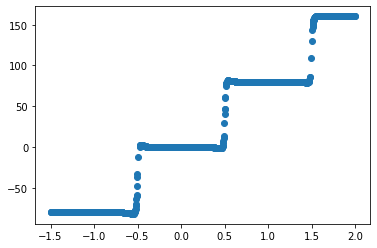

In [132]:
lossessteps1 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [133]:
MSE(y_pred.flatten(), Y_test)

15.213871474520161

### tanh

In [58]:
nn = NeuralNetwork(1,[32,32,1],["tanh","tanh","linear"],["uniform","uniform","uniform"])
nn.compile(loss = "MSE",optimizer = "BGD", lr = 0.00005)

In [59]:
nn.fit(X_train_std.copy(), Y_train.copy(), epochs = 1000, batch_size=32)

Epoch 1/1000 - loss: 1433.1872956976458
Epoch 2/1000 - loss: 567.1640734407947
Epoch 3/1000 - loss: 492.33419152375507
Epoch 4/1000 - loss: 287.3712134018956
Epoch 5/1000 - loss: 261.7642989571231
Epoch 6/1000 - loss: 204.0786477285078
Epoch 7/1000 - loss: 204.53403006507935
Epoch 8/1000 - loss: 176.6210339594033
Epoch 9/1000 - loss: 166.1144479020932
Epoch 10/1000 - loss: 172.01946675871747
Epoch 11/1000 - loss: 159.67775101100486
Epoch 12/1000 - loss: 125.74855897651378
Epoch 13/1000 - loss: 118.13657254319017
Epoch 14/1000 - loss: 126.41821989627277
Epoch 15/1000 - loss: 135.0486861728004
Epoch 16/1000 - loss: 121.57719835647738
Epoch 17/1000 - loss: 135.81007967625786
Epoch 18/1000 - loss: 91.42691890614057
Epoch 19/1000 - loss: 124.49856040190608
Epoch 20/1000 - loss: 100.46084759451522
Epoch 21/1000 - loss: 95.65377826625298
Epoch 22/1000 - loss: 88.60982678724244
Epoch 23/1000 - loss: 113.44954681802275
Epoch 24/1000 - loss: 107.01138241472071
Epoch 25/1000 - loss: 78.1389742100

Epoch 203/1000 - loss: 39.88291074237625
Epoch 204/1000 - loss: 33.9777988153378
Epoch 205/1000 - loss: 36.21138431960464
Epoch 206/1000 - loss: 38.68665823537331
Epoch 207/1000 - loss: 29.135152888437197
Epoch 208/1000 - loss: 35.020982636550876
Epoch 209/1000 - loss: 30.264461450175904
Epoch 210/1000 - loss: 29.14159857073411
Epoch 211/1000 - loss: 32.358916610726695
Epoch 212/1000 - loss: 46.7298951051608
Epoch 213/1000 - loss: 30.743329972475568
Epoch 214/1000 - loss: 25.68626699305419
Epoch 215/1000 - loss: 39.27111599238533
Epoch 216/1000 - loss: 31.909656601515987
Epoch 217/1000 - loss: 38.2740742695934
Epoch 218/1000 - loss: 39.28404301177236
Epoch 219/1000 - loss: 23.88101698091139
Epoch 220/1000 - loss: 54.355364101285396
Epoch 221/1000 - loss: 32.894813884349965
Epoch 222/1000 - loss: 33.97552286317728
Epoch 223/1000 - loss: 32.49086381185248
Epoch 224/1000 - loss: 33.926994012794886
Epoch 225/1000 - loss: 38.40064454527991
Epoch 226/1000 - loss: 40.87449828127538
Epoch 227/

Epoch 402/1000 - loss: 21.656350082747302
Epoch 403/1000 - loss: 27.338513440496143
Epoch 404/1000 - loss: 21.82038723181359
Epoch 405/1000 - loss: 39.116846642730785
Epoch 406/1000 - loss: 35.145199087202364
Epoch 407/1000 - loss: 24.391888413665075
Epoch 408/1000 - loss: 30.779254290120974
Epoch 409/1000 - loss: 29.503246081203454
Epoch 410/1000 - loss: 33.30511158494924
Epoch 411/1000 - loss: 30.202533785228372
Epoch 412/1000 - loss: 37.86341940343831
Epoch 413/1000 - loss: 29.05034940572228
Epoch 414/1000 - loss: 30.955523996400867
Epoch 415/1000 - loss: 26.269964597166968
Epoch 416/1000 - loss: 21.704176493252472
Epoch 417/1000 - loss: 23.50625428606537
Epoch 418/1000 - loss: 23.794014643875283
Epoch 419/1000 - loss: 38.92519450293837
Epoch 420/1000 - loss: 33.26690977321829
Epoch 421/1000 - loss: 33.056994990217106
Epoch 422/1000 - loss: 24.423210086654034
Epoch 423/1000 - loss: 26.900518288875638
Epoch 424/1000 - loss: 31.24029781589225
Epoch 425/1000 - loss: 30.961493487392787


Epoch 600/1000 - loss: 23.113385618292554
Epoch 601/1000 - loss: 20.747607230275875
Epoch 602/1000 - loss: 25.36007264058315
Epoch 603/1000 - loss: 19.763073460940795
Epoch 604/1000 - loss: 30.464102776854613
Epoch 605/1000 - loss: 19.51869464885675
Epoch 606/1000 - loss: 22.239317731790013
Epoch 607/1000 - loss: 18.221717173854316
Epoch 608/1000 - loss: 28.18543123464855
Epoch 609/1000 - loss: 28.606056624760736
Epoch 610/1000 - loss: 23.12862655545341
Epoch 611/1000 - loss: 17.446471680680684
Epoch 612/1000 - loss: 25.061116056532924
Epoch 613/1000 - loss: 28.853197313214984
Epoch 614/1000 - loss: 22.849118465456
Epoch 615/1000 - loss: 27.62368538993882
Epoch 616/1000 - loss: 20.21479122322392
Epoch 617/1000 - loss: 26.302042937687254
Epoch 618/1000 - loss: 25.89920592861285
Epoch 619/1000 - loss: 19.94241298662388
Epoch 620/1000 - loss: 24.161656774941292
Epoch 621/1000 - loss: 19.705539315978086
Epoch 622/1000 - loss: 25.90354935394594
Epoch 623/1000 - loss: 25.154924095673874
Epoc

Epoch 798/1000 - loss: 20.896756126446444
Epoch 799/1000 - loss: 17.766561683017436
Epoch 800/1000 - loss: 20.953674886020927
Epoch 801/1000 - loss: 38.82842506066896
Epoch 802/1000 - loss: 19.869987815221684
Epoch 803/1000 - loss: 29.496690271136938
Epoch 804/1000 - loss: 19.55794617984522
Epoch 805/1000 - loss: 23.26893880736363
Epoch 806/1000 - loss: 20.033482917797084
Epoch 807/1000 - loss: 21.80674029544
Epoch 808/1000 - loss: 15.461489884176661
Epoch 809/1000 - loss: 17.148124354220965
Epoch 810/1000 - loss: 18.135576439441888
Epoch 811/1000 - loss: 19.65098408980275
Epoch 812/1000 - loss: 22.911906361329695
Epoch 813/1000 - loss: 20.860783376345992
Epoch 814/1000 - loss: 25.57373975714226
Epoch 815/1000 - loss: 22.023524708446633
Epoch 816/1000 - loss: 18.83942202140567
Epoch 817/1000 - loss: 22.164094130785944
Epoch 818/1000 - loss: 15.753052043320348
Epoch 819/1000 - loss: 21.718131012715663
Epoch 820/1000 - loss: 17.91508669060932
Epoch 821/1000 - loss: 23.53321987189999
Epoc

Epoch 995/1000 - loss: 19.924414434042102
Epoch 996/1000 - loss: 22.97177116847118
Epoch 997/1000 - loss: 26.399029397038028
Epoch 998/1000 - loss: 17.535448840254364
Epoch 999/1000 - loss: 25.073325246236305
Epoch 1000/1000 - loss: 16.23833447711356


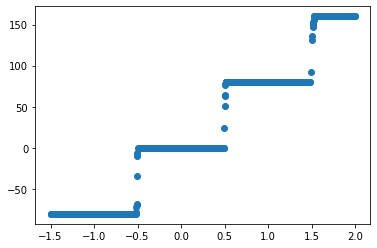

In [60]:
lossessteps2 = nn.losses
y_pred = nn.predict(X_test_std)
plt.scatter(X_test, y_pred)
plt.show()

In [61]:
MSE(y_pred.flatten(), Y_test)

17.028147437467453

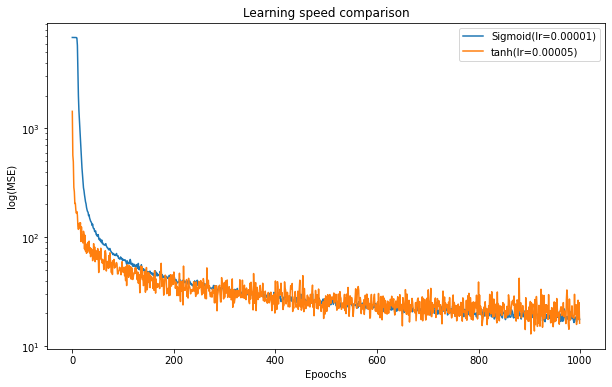

In [140]:
plt.figure(figsize=(10,6))
plt.plot(lossessteps1,label="Sigmoid(lr=0.00001)")
plt.plot(lossessteps2,label="tanh(lr=0.00005)")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(MSE)')
plt.yscale("log")
plt.legend()
plt.show()

# rings5-regular

In [4]:
train_df = pd.read_csv("data/rings5-regular-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/rings5-regular-test.csv",index_col=0).reset_index()

In [ ]:
X_train = np.reshape(train_df[["x","y"]].values,(len(train_df),2))
Y_train = np.reshape(train_df["c"].values,(len(train_df),1))

In [5]:
X_test = np.reshape(test_df[["x","y"]].values,(len(test_df),2))
Y_test = np.reshape(test_df["c"].values,(len(test_df),1))

#### Normalize the data

In [64]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### tanh

In [65]:
nn = NeuralNetwork(2,[20,20,5],["tanh","tanh","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001)

In [66]:
y_train = makey_rings5(Y_train)
nn.fit(X_train.copy(), y_train, epochs = 2000, batch_size = 32)

Epoch 1/2000 - loss: 2.90976637061129
Epoch 2/2000 - loss: 2.9075125308910175
Epoch 3/2000 - loss: 2.8753784375356126
Epoch 4/2000 - loss: 2.8470597976200795
Epoch 5/2000 - loss: 2.8236040509026394
Epoch 6/2000 - loss: 2.789715489518846
Epoch 7/2000 - loss: 2.750918141728765
Epoch 8/2000 - loss: 2.721556927043226
Epoch 9/2000 - loss: 2.6942151504484517
Epoch 10/2000 - loss: 2.6847314142237972
Epoch 11/2000 - loss: 2.671511734522377
Epoch 12/2000 - loss: 2.655929819129349
Epoch 13/2000 - loss: 2.646311804710691
Epoch 14/2000 - loss: 2.6461652245566896
Epoch 15/2000 - loss: 2.64089131061974
Epoch 16/2000 - loss: 2.6264705410065017
Epoch 17/2000 - loss: 2.634965909590705
Epoch 18/2000 - loss: 2.6267566615565605
Epoch 19/2000 - loss: 2.6253066058185675
Epoch 20/2000 - loss: 2.6257971176621675
Epoch 21/2000 - loss: 2.627404413603272
Epoch 22/2000 - loss: 2.6255545048527456
Epoch 23/2000 - loss: 2.615854045458817
Epoch 24/2000 - loss: 2.616524770000219
Epoch 25/2000 - loss: 2.614498202644961

Epoch 201/2000 - loss: 2.2710030923175406
Epoch 202/2000 - loss: 2.2754582953740523
Epoch 203/2000 - loss: 2.2962245044342593
Epoch 204/2000 - loss: 2.3014209399814916
Epoch 205/2000 - loss: 2.337111224442311
Epoch 206/2000 - loss: 2.3337647165851916
Epoch 207/2000 - loss: 2.300161930520595
Epoch 208/2000 - loss: 2.2948746275438463
Epoch 209/2000 - loss: 2.3039326351102947
Epoch 210/2000 - loss: 2.3365110914858236
Epoch 211/2000 - loss: 2.317158935578729
Epoch 212/2000 - loss: 2.315232521109427
Epoch 213/2000 - loss: 2.30848135006696
Epoch 214/2000 - loss: 2.265936640891894
Epoch 215/2000 - loss: 2.2751402833854533
Epoch 216/2000 - loss: 2.2817193686988153
Epoch 217/2000 - loss: 2.24274794871698
Epoch 218/2000 - loss: 2.3360167126451357
Epoch 219/2000 - loss: 2.2879766128796155
Epoch 220/2000 - loss: 2.2548848749454202
Epoch 221/2000 - loss: 2.2716697263961856
Epoch 222/2000 - loss: 2.2177585379686127
Epoch 223/2000 - loss: 2.2864534498973206
Epoch 224/2000 - loss: 2.28161805404506
Epo

Epoch 399/2000 - loss: 2.05814028060494
Epoch 400/2000 - loss: 2.0185081203158792
Epoch 401/2000 - loss: 2.11050332994309
Epoch 402/2000 - loss: 2.1156071730967283
Epoch 403/2000 - loss: 2.1540425224412316
Epoch 404/2000 - loss: 2.1575706698920647
Epoch 405/2000 - loss: 2.098514934940157
Epoch 406/2000 - loss: 2.0792508641596026
Epoch 407/2000 - loss: 2.101229905603266
Epoch 408/2000 - loss: 2.071940372316815
Epoch 409/2000 - loss: 2.094462456529594
Epoch 410/2000 - loss: 2.0801957880196382
Epoch 411/2000 - loss: 2.071802469611847
Epoch 412/2000 - loss: 2.1016383074052474
Epoch 413/2000 - loss: 2.039201603567774
Epoch 414/2000 - loss: 2.0452010242106264
Epoch 415/2000 - loss: 2.0812594302711256
Epoch 416/2000 - loss: 2.0580231168840717
Epoch 417/2000 - loss: 2.009550461491036
Epoch 418/2000 - loss: 1.9913698853210489
Epoch 419/2000 - loss: 2.0288839869416266
Epoch 420/2000 - loss: 2.075605285879928
Epoch 421/2000 - loss: 2.001043011996007
Epoch 422/2000 - loss: 1.9653218094526759
Epoch

Epoch 596/2000 - loss: 1.86831322823324
Epoch 597/2000 - loss: 1.8101262006484913
Epoch 598/2000 - loss: 1.8891447310503642
Epoch 599/2000 - loss: 1.971244324609061
Epoch 600/2000 - loss: 1.8295677181368089
Epoch 601/2000 - loss: 1.8138477473756431
Epoch 602/2000 - loss: 1.7759550306929135
Epoch 603/2000 - loss: 1.8119660996420606
Epoch 604/2000 - loss: 1.85425727726437
Epoch 605/2000 - loss: 1.812681038683384
Epoch 606/2000 - loss: 1.824525830456206
Epoch 607/2000 - loss: 1.7632829254105733
Epoch 608/2000 - loss: 1.9730025494834256
Epoch 609/2000 - loss: 1.8922099039977678
Epoch 610/2000 - loss: 1.9964926682969648
Epoch 611/2000 - loss: 1.8404840575930954
Epoch 612/2000 - loss: 1.8260032787200857
Epoch 613/2000 - loss: 1.867062866105151
Epoch 614/2000 - loss: 1.863976765108261
Epoch 615/2000 - loss: 1.8256277877548015
Epoch 616/2000 - loss: 2.002259426831878
Epoch 617/2000 - loss: 2.060389194031008
Epoch 618/2000 - loss: 1.9455311587583577
Epoch 619/2000 - loss: 1.9192868650901123
Epo

Epoch 793/2000 - loss: 1.8454367029446384
Epoch 794/2000 - loss: 1.8423428156633148
Epoch 795/2000 - loss: 1.907197960605301
Epoch 796/2000 - loss: 1.879157737348743
Epoch 797/2000 - loss: 1.818556700762143
Epoch 798/2000 - loss: 1.7542131128663563
Epoch 799/2000 - loss: 1.7709881844330457
Epoch 800/2000 - loss: 1.8202343707082331
Epoch 801/2000 - loss: 1.9326157736639062
Epoch 802/2000 - loss: 1.8430057449343067
Epoch 803/2000 - loss: 1.843741687902479
Epoch 804/2000 - loss: 1.8341673903894518
Epoch 805/2000 - loss: 1.9173631622761156
Epoch 806/2000 - loss: 1.9440658601277607
Epoch 807/2000 - loss: 1.8260990293873922
Epoch 808/2000 - loss: 1.7711861012563233
Epoch 809/2000 - loss: 1.8484107582400668
Epoch 810/2000 - loss: 1.7574901337560884
Epoch 811/2000 - loss: 1.8044037022738333
Epoch 812/2000 - loss: 1.7902080943423746
Epoch 813/2000 - loss: 1.8244712137994654
Epoch 814/2000 - loss: 1.75386054137345
Epoch 815/2000 - loss: 1.8088932157751254
Epoch 816/2000 - loss: 1.783146068165364

Epoch 989/2000 - loss: 1.6573482185803943
Epoch 990/2000 - loss: 1.6825269488282106
Epoch 991/2000 - loss: 1.6626802894170873
Epoch 992/2000 - loss: 1.7717328097279195
Epoch 993/2000 - loss: 1.733215078313979
Epoch 994/2000 - loss: 1.808423878179174
Epoch 995/2000 - loss: 1.7706947132704052
Epoch 996/2000 - loss: 1.719322077988202
Epoch 997/2000 - loss: 1.8726920076692983
Epoch 998/2000 - loss: 1.820988043707575
Epoch 999/2000 - loss: 1.8243246088654428
Epoch 1000/2000 - loss: 1.7827206804879394
Epoch 1001/2000 - loss: 1.8367436211688573
Epoch 1002/2000 - loss: 1.848591781315069
Epoch 1003/2000 - loss: 1.7801937792533962
Epoch 1004/2000 - loss: 1.7580609238040343
Epoch 1005/2000 - loss: 1.7494504752067606
Epoch 1006/2000 - loss: 1.6994037073851689
Epoch 1007/2000 - loss: 1.8518313020083954
Epoch 1008/2000 - loss: 2.0271407612494623
Epoch 1009/2000 - loss: 2.026607986039371
Epoch 1010/2000 - loss: 2.0416419746169474
Epoch 1011/2000 - loss: 2.0069800472448347
Epoch 1012/2000 - loss: 1.90

Epoch 1181/2000 - loss: 1.9692878424878377
Epoch 1182/2000 - loss: 2.0275706210316935
Epoch 1183/2000 - loss: 2.018343709599793
Epoch 1184/2000 - loss: 1.9508250829401965
Epoch 1185/2000 - loss: 1.9823230738529367
Epoch 1186/2000 - loss: 1.9668467873657884
Epoch 1187/2000 - loss: 2.057092002549733
Epoch 1188/2000 - loss: 2.019602722286473
Epoch 1189/2000 - loss: 1.9310133510630252
Epoch 1190/2000 - loss: 1.8957354747543258
Epoch 1191/2000 - loss: 1.9678286087891492
Epoch 1192/2000 - loss: 1.8977155345566117
Epoch 1193/2000 - loss: 1.945804276982033
Epoch 1194/2000 - loss: 1.968864331446002
Epoch 1195/2000 - loss: 1.9669818133772439
Epoch 1196/2000 - loss: 1.92952045733177
Epoch 1197/2000 - loss: 1.9101004499316325
Epoch 1198/2000 - loss: 1.993284003704035
Epoch 1199/2000 - loss: 1.9287064756097936
Epoch 1200/2000 - loss: 1.9281585284863698
Epoch 1201/2000 - loss: 1.9169770800464991
Epoch 1202/2000 - loss: 1.9176010112786985
Epoch 1203/2000 - loss: 1.9551632080628083
Epoch 1204/2000 - l

Epoch 1373/2000 - loss: 1.7361146798485383
Epoch 1374/2000 - loss: 1.7514754688169853
Epoch 1375/2000 - loss: 1.7254108771725476
Epoch 1376/2000 - loss: 1.7285999773732323
Epoch 1377/2000 - loss: 1.7907364567711486
Epoch 1378/2000 - loss: 1.7667755987481946
Epoch 1379/2000 - loss: 1.7642176948397732
Epoch 1380/2000 - loss: 1.7740167582968993
Epoch 1381/2000 - loss: 1.7028534121461434
Epoch 1382/2000 - loss: 1.722003117309963
Epoch 1383/2000 - loss: 1.7476659999054662
Epoch 1384/2000 - loss: 1.748074767219445
Epoch 1385/2000 - loss: 1.7450238324437937
Epoch 1386/2000 - loss: 1.7298146919334099
Epoch 1387/2000 - loss: 1.7340456059858942
Epoch 1388/2000 - loss: 1.7562591355517558
Epoch 1389/2000 - loss: 1.8023438753883325
Epoch 1390/2000 - loss: 1.7750574551755451
Epoch 1391/2000 - loss: 1.7845036646052097
Epoch 1392/2000 - loss: 1.8643115991182584
Epoch 1393/2000 - loss: 1.8603407740808953
Epoch 1394/2000 - loss: 1.9161883452856698
Epoch 1395/2000 - loss: 1.8448124827964048
Epoch 1396/20

Epoch 1565/2000 - loss: 1.6790452754402183
Epoch 1566/2000 - loss: 1.703917167020528
Epoch 1567/2000 - loss: 1.6999433037561185
Epoch 1568/2000 - loss: 1.6628471617826395
Epoch 1569/2000 - loss: 1.6787538873788563
Epoch 1570/2000 - loss: 1.677003267327303
Epoch 1571/2000 - loss: 1.723769435570158
Epoch 1572/2000 - loss: 1.6478828861369372
Epoch 1573/2000 - loss: 1.637964971479347
Epoch 1574/2000 - loss: 1.7176803469043174
Epoch 1575/2000 - loss: 1.7352171261886915
Epoch 1576/2000 - loss: 1.7344539314665937
Epoch 1577/2000 - loss: 1.7006674539424511
Epoch 1578/2000 - loss: 1.6469866116532677
Epoch 1579/2000 - loss: 1.6877858834328445
Epoch 1580/2000 - loss: 1.6323619331294548
Epoch 1581/2000 - loss: 1.7017081964381697
Epoch 1582/2000 - loss: 1.6720488641692288
Epoch 1583/2000 - loss: 1.6419236155274464
Epoch 1584/2000 - loss: 1.6538319304497708
Epoch 1585/2000 - loss: 1.6787542466941627
Epoch 1586/2000 - loss: 1.6260555600617328
Epoch 1587/2000 - loss: 1.6494825747175579
Epoch 1588/2000

Epoch 1757/2000 - loss: 1.843211640375499
Epoch 1758/2000 - loss: 1.8064688666667463
Epoch 1759/2000 - loss: 1.6888187086786848
Epoch 1760/2000 - loss: 1.6932938317163342
Epoch 1761/2000 - loss: 1.6931175034779054
Epoch 1762/2000 - loss: 1.6721191000358806
Epoch 1763/2000 - loss: 1.6512830068182747
Epoch 1764/2000 - loss: 1.69891866712291
Epoch 1765/2000 - loss: 1.6769886293611336
Epoch 1766/2000 - loss: 1.7031246869571892
Epoch 1767/2000 - loss: 1.7302158058194572
Epoch 1768/2000 - loss: 1.8932965203571888
Epoch 1769/2000 - loss: 1.8356686052882618
Epoch 1770/2000 - loss: 1.749117046846429
Epoch 1771/2000 - loss: 1.7530738956732612
Epoch 1772/2000 - loss: 1.6877635252863699
Epoch 1773/2000 - loss: 1.6700458347295895
Epoch 1774/2000 - loss: 1.6233979445159312
Epoch 1775/2000 - loss: 1.6325594375223562
Epoch 1776/2000 - loss: 1.6924087185935601
Epoch 1777/2000 - loss: 1.6194688683804401
Epoch 1778/2000 - loss: 1.6355458248834358
Epoch 1779/2000 - loss: 1.599517204063568
Epoch 1780/2000 

Epoch 1949/2000 - loss: 1.616431578165667
Epoch 1950/2000 - loss: 1.6332845913452192
Epoch 1951/2000 - loss: 1.633272964079404
Epoch 1952/2000 - loss: 1.5936188204267423
Epoch 1953/2000 - loss: 1.6182280937752773
Epoch 1954/2000 - loss: 1.6068384304305607
Epoch 1955/2000 - loss: 1.751157934731901
Epoch 1956/2000 - loss: 1.7496312177142752
Epoch 1957/2000 - loss: 1.5991698554257536
Epoch 1958/2000 - loss: 1.603231992775837
Epoch 1959/2000 - loss: 1.6251298475344136
Epoch 1960/2000 - loss: 1.5857794445828912
Epoch 1961/2000 - loss: 1.6119545586577992
Epoch 1962/2000 - loss: 1.6356952433243819
Epoch 1963/2000 - loss: 1.6090293602272177
Epoch 1964/2000 - loss: 1.6096762811923542
Epoch 1965/2000 - loss: 1.64005389473598
Epoch 1966/2000 - loss: 1.764606407158444
Epoch 1967/2000 - loss: 1.6470689820460422
Epoch 1968/2000 - loss: 1.6585292504410172
Epoch 1969/2000 - loss: 1.7310005991187352
Epoch 1970/2000 - loss: 1.6396975931557585
Epoch 1971/2000 - loss: 1.6479805013373994
Epoch 1972/2000 - 

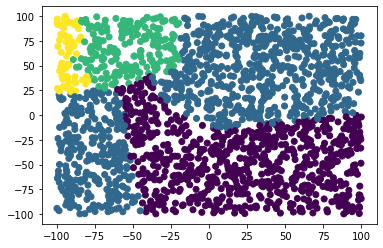

In [67]:
lossesrings51 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=-1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

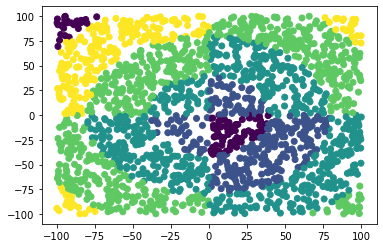

In [68]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [69]:
f1_score(Y_test.flatten(), y_pred,average="macro")

0.0467540741491526

### Sigmoid

In [131]:
nn = NeuralNetwork(2,[20,20,5],["sigmoid","sigmoid","softmax"],["uniform","uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.01)

In [132]:
y_train = makey_rings5(Y_train)
nn.fit(X_train_std.copy(), y_train, epochs = 2000, batch_size = 32)

Epoch 1/2000 - loss: 2.95710574665718
Epoch 2/2000 - loss: 2.934566759655155
Epoch 3/2000 - loss: 2.9545970340088115
Epoch 4/2000 - loss: 2.951302462790206
Epoch 5/2000 - loss: 2.945897777712868
Epoch 6/2000 - loss: 2.9482930677330166
Epoch 7/2000 - loss: 2.951943428662747
Epoch 8/2000 - loss: 2.9602314258068523
Epoch 9/2000 - loss: 2.950342672986477
Epoch 10/2000 - loss: 2.933909775167471
Epoch 11/2000 - loss: 2.952505917993443
Epoch 12/2000 - loss: 2.929918359527968
Epoch 13/2000 - loss: 2.926293179510926
Epoch 14/2000 - loss: 2.933303046371417
Epoch 15/2000 - loss: 2.936075633245627
Epoch 16/2000 - loss: 2.95217925236078
Epoch 17/2000 - loss: 2.9378593082492075
Epoch 18/2000 - loss: 2.9302434767145313
Epoch 19/2000 - loss: 2.943961235510161
Epoch 20/2000 - loss: 2.954929914285224
Epoch 21/2000 - loss: 2.935138453869048
Epoch 22/2000 - loss: 2.91725123911554
Epoch 23/2000 - loss: 2.879859211157282
Epoch 24/2000 - loss: 2.869480614276736
Epoch 25/2000 - loss: 2.819650806580786
Epoch 2

Epoch 201/2000 - loss: 1.1749105232107269
Epoch 202/2000 - loss: 1.189177242719742
Epoch 203/2000 - loss: 1.1841969891838395
Epoch 204/2000 - loss: 1.1721243612317571
Epoch 205/2000 - loss: 1.1628032950887701
Epoch 206/2000 - loss: 1.1342287798195867
Epoch 207/2000 - loss: 1.1556426747089528
Epoch 208/2000 - loss: 1.1395591601084676
Epoch 209/2000 - loss: 1.1412562489768578
Epoch 210/2000 - loss: 1.1250866794929884
Epoch 211/2000 - loss: 1.1332901859041211
Epoch 212/2000 - loss: 1.1041148597200567
Epoch 213/2000 - loss: 1.0909544715489305
Epoch 214/2000 - loss: 1.1095587106928273
Epoch 215/2000 - loss: 1.081366719971682
Epoch 216/2000 - loss: 1.0976993322157458
Epoch 217/2000 - loss: 1.0795124258048263
Epoch 218/2000 - loss: 1.103216435114519
Epoch 219/2000 - loss: 1.0448385651292875
Epoch 220/2000 - loss: 1.0399923205357402
Epoch 221/2000 - loss: 1.0319834732175206
Epoch 222/2000 - loss: 1.0296487125868026
Epoch 223/2000 - loss: 1.0472734047181818
Epoch 224/2000 - loss: 1.020719192163

Epoch 397/2000 - loss: 0.5572951297166906
Epoch 398/2000 - loss: 0.5442554577076588
Epoch 399/2000 - loss: 0.5316182543346157
Epoch 400/2000 - loss: 0.5353643237856901
Epoch 401/2000 - loss: 0.5299978933508054
Epoch 402/2000 - loss: 0.5371511286147568
Epoch 403/2000 - loss: 0.5252927110345698
Epoch 404/2000 - loss: 0.5316222471593405
Epoch 405/2000 - loss: 0.5393602447866969
Epoch 406/2000 - loss: 0.534707275727522
Epoch 407/2000 - loss: 0.5261964203457988
Epoch 408/2000 - loss: 0.5255912363193674
Epoch 409/2000 - loss: 0.5280298995594224
Epoch 410/2000 - loss: 0.530662892855552
Epoch 411/2000 - loss: 0.5229149478310312
Epoch 412/2000 - loss: 0.5332013187185338
Epoch 413/2000 - loss: 0.5142162245815491
Epoch 414/2000 - loss: 0.5161776556382637
Epoch 415/2000 - loss: 0.5294481089383871
Epoch 416/2000 - loss: 0.5345748113519455
Epoch 417/2000 - loss: 0.5175266209985788
Epoch 418/2000 - loss: 0.5219619554206036
Epoch 419/2000 - loss: 0.531141506331235
Epoch 420/2000 - loss: 0.513400171620

Epoch 591/2000 - loss: 0.38289195392837494
Epoch 592/2000 - loss: 0.41292937451662093
Epoch 593/2000 - loss: 0.3928445363452198
Epoch 594/2000 - loss: 0.3951026883264994
Epoch 595/2000 - loss: 0.3896705737006781
Epoch 596/2000 - loss: 0.3891003057955425
Epoch 597/2000 - loss: 0.40513222799742726
Epoch 598/2000 - loss: 0.39353621986929765
Epoch 599/2000 - loss: 0.3847065082468167
Epoch 600/2000 - loss: 0.3873877092912962
Epoch 601/2000 - loss: 0.40070139775818686
Epoch 602/2000 - loss: 0.38585409307639673
Epoch 603/2000 - loss: 0.38604787458308804
Epoch 604/2000 - loss: 0.3823074845642895
Epoch 605/2000 - loss: 0.39131201537153254
Epoch 606/2000 - loss: 0.3844033989536413
Epoch 607/2000 - loss: 0.3912880929170929
Epoch 608/2000 - loss: 0.3892270307063764
Epoch 609/2000 - loss: 0.37449932944304587
Epoch 610/2000 - loss: 0.37809696203270265
Epoch 611/2000 - loss: 0.37606154453966706
Epoch 612/2000 - loss: 0.3902071917364675
Epoch 613/2000 - loss: 0.38523534036237705
Epoch 614/2000 - loss:

Epoch 785/2000 - loss: 0.3045761007742156
Epoch 786/2000 - loss: 0.3224862265478457
Epoch 787/2000 - loss: 0.3091080451605401
Epoch 788/2000 - loss: 0.30658769360301774
Epoch 789/2000 - loss: 0.30320306611819214
Epoch 790/2000 - loss: 0.30910385165317683
Epoch 791/2000 - loss: 0.3041924276353691
Epoch 792/2000 - loss: 0.31756035243947384
Epoch 793/2000 - loss: 0.31582593428793015
Epoch 794/2000 - loss: 0.303140554377901
Epoch 795/2000 - loss: 0.31551756994798996
Epoch 796/2000 - loss: 0.30242956222547174
Epoch 797/2000 - loss: 0.308455166161414
Epoch 798/2000 - loss: 0.30898724298304786
Epoch 799/2000 - loss: 0.31266335198882117
Epoch 800/2000 - loss: 0.30853681595025384
Epoch 801/2000 - loss: 0.30176120432820314
Epoch 802/2000 - loss: 0.30919387298770945
Epoch 803/2000 - loss: 0.29785545465102337
Epoch 804/2000 - loss: 0.301744706233304
Epoch 805/2000 - loss: 0.3009850775359769
Epoch 806/2000 - loss: 0.3046144141947517
Epoch 807/2000 - loss: 0.29267212762150435
Epoch 808/2000 - loss: 

Epoch 979/2000 - loss: 0.24459694867170972
Epoch 980/2000 - loss: 0.24258283109269316
Epoch 981/2000 - loss: 0.25477966131827207
Epoch 982/2000 - loss: 0.2473730339637568
Epoch 983/2000 - loss: 0.2528011094831638
Epoch 984/2000 - loss: 0.2536948282948067
Epoch 985/2000 - loss: 0.2478349065913772
Epoch 986/2000 - loss: 0.2619226939771332
Epoch 987/2000 - loss: 0.2515108218181239
Epoch 988/2000 - loss: 0.2442681177724292
Epoch 989/2000 - loss: 0.25735588184186203
Epoch 990/2000 - loss: 0.21926545463450334
Epoch 991/2000 - loss: 0.25639453967201675
Epoch 992/2000 - loss: 0.24764148286858434
Epoch 993/2000 - loss: 0.24918868427463997
Epoch 994/2000 - loss: 0.2432249866369955
Epoch 995/2000 - loss: 0.24151353458610297
Epoch 996/2000 - loss: 0.23816626813311906
Epoch 997/2000 - loss: 0.23755695698753956
Epoch 998/2000 - loss: 0.2492851898263041
Epoch 999/2000 - loss: 0.24835481123714817
Epoch 1000/2000 - loss: 0.25497605670553625
Epoch 1001/2000 - loss: 0.24197248725767476
Epoch 1002/2000 - 

Epoch 1167/2000 - loss: 0.21366820290907212
Epoch 1168/2000 - loss: 0.2035035534557003
Epoch 1169/2000 - loss: 0.2137818799533666
Epoch 1170/2000 - loss: 0.1998282302698672
Epoch 1171/2000 - loss: 0.2116040178524782
Epoch 1172/2000 - loss: 0.20578114987728896
Epoch 1173/2000 - loss: 0.21208580470477817
Epoch 1174/2000 - loss: 0.2220407430639281
Epoch 1175/2000 - loss: 0.20689118865272213
Epoch 1176/2000 - loss: 0.20965638675889867
Epoch 1177/2000 - loss: 0.20879351409199454
Epoch 1178/2000 - loss: 0.21040062897410516
Epoch 1179/2000 - loss: 0.20314784277566308
Epoch 1180/2000 - loss: 0.19822333928918168
Epoch 1181/2000 - loss: 0.20435255156489646
Epoch 1182/2000 - loss: 0.21485577078981485
Epoch 1183/2000 - loss: 0.2095968510954914
Epoch 1184/2000 - loss: 0.19989392380395304
Epoch 1185/2000 - loss: 0.21020442541235235
Epoch 1186/2000 - loss: 0.20635730922050444
Epoch 1187/2000 - loss: 0.20750594335136008
Epoch 1188/2000 - loss: 0.2038693753290828
Epoch 1189/2000 - loss: 0.2079955687269

Epoch 1355/2000 - loss: 0.1691932415848237
Epoch 1356/2000 - loss: 0.17946452628954743
Epoch 1357/2000 - loss: 0.1782264245926452
Epoch 1358/2000 - loss: 0.17851434880378153
Epoch 1359/2000 - loss: 0.18082729910515277
Epoch 1360/2000 - loss: 0.17993892977481973
Epoch 1361/2000 - loss: 0.1787048037271112
Epoch 1362/2000 - loss: 0.1782774980059503
Epoch 1363/2000 - loss: 0.18077326560377482
Epoch 1364/2000 - loss: 0.17315281178837372
Epoch 1365/2000 - loss: 0.17607711444184565
Epoch 1366/2000 - loss: 0.17664735790547306
Epoch 1367/2000 - loss: 0.17337785904495642
Epoch 1368/2000 - loss: 0.18505798275738983
Epoch 1369/2000 - loss: 0.1838691647903274
Epoch 1370/2000 - loss: 0.18077544232245393
Epoch 1371/2000 - loss: 0.17407100564292027
Epoch 1372/2000 - loss: 0.17636089699424348
Epoch 1373/2000 - loss: 0.17528198107250978
Epoch 1374/2000 - loss: 0.1750647627887286
Epoch 1375/2000 - loss: 0.1678028364079603
Epoch 1376/2000 - loss: 0.1736937813069784
Epoch 1377/2000 - loss: 0.17285836356527

Epoch 1543/2000 - loss: 0.14930608642603627
Epoch 1544/2000 - loss: 0.15013252894046186
Epoch 1545/2000 - loss: 0.16307663368411257
Epoch 1546/2000 - loss: 0.1498698512015439
Epoch 1547/2000 - loss: 0.15535530119417257
Epoch 1548/2000 - loss: 0.15715773592643065
Epoch 1549/2000 - loss: 0.1525011504607555
Epoch 1550/2000 - loss: 0.15665472391808458
Epoch 1551/2000 - loss: 0.14820805212186053
Epoch 1552/2000 - loss: 0.16312234350434482
Epoch 1553/2000 - loss: 0.14629376008796985
Epoch 1554/2000 - loss: 0.15107097699428607
Epoch 1555/2000 - loss: 0.14129276433683624
Epoch 1556/2000 - loss: 0.14825392322983683
Epoch 1557/2000 - loss: 0.16203254866061245
Epoch 1558/2000 - loss: 0.15644763004944684
Epoch 1559/2000 - loss: 0.14666089670963123
Epoch 1560/2000 - loss: 0.15418927148170883
Epoch 1561/2000 - loss: 0.1450642589818104
Epoch 1562/2000 - loss: 0.15347553005990824
Epoch 1563/2000 - loss: 0.1521913139895947
Epoch 1564/2000 - loss: 0.16660131376568887
Epoch 1565/2000 - loss: 0.1520781942

Epoch 1731/2000 - loss: 0.14598428334218597
Epoch 1732/2000 - loss: 0.1419608865556585
Epoch 1733/2000 - loss: 0.14113591297934408
Epoch 1734/2000 - loss: 0.14485719934117383
Epoch 1735/2000 - loss: 0.14462437482254817
Epoch 1736/2000 - loss: 0.13899383819592914
Epoch 1737/2000 - loss: 0.13752786889177204
Epoch 1738/2000 - loss: 0.13693427698027966
Epoch 1739/2000 - loss: 0.13777352044578167
Epoch 1740/2000 - loss: 0.13208352304239102
Epoch 1741/2000 - loss: 0.13525819794891977
Epoch 1742/2000 - loss: 0.13980002827280794
Epoch 1743/2000 - loss: 0.14426775969465463
Epoch 1744/2000 - loss: 0.12888332521788495
Epoch 1745/2000 - loss: 0.13829112503933078
Epoch 1746/2000 - loss: 0.1374072695095126
Epoch 1747/2000 - loss: 0.13918268010441395
Epoch 1748/2000 - loss: 0.14505550744355217
Epoch 1749/2000 - loss: 0.14657561455949494
Epoch 1750/2000 - loss: 0.14377621008911926
Epoch 1751/2000 - loss: 0.13787833640481298
Epoch 1752/2000 - loss: 0.140566661567586
Epoch 1753/2000 - loss: 0.1376875101

Epoch 1919/2000 - loss: 0.12394185922503322
Epoch 1920/2000 - loss: 0.12189563040728137
Epoch 1921/2000 - loss: 0.134975178137158
Epoch 1922/2000 - loss: 0.12812363884917474
Epoch 1923/2000 - loss: 0.1319100298492016
Epoch 1924/2000 - loss: 0.12131007069751558
Epoch 1925/2000 - loss: 0.13100520929951218
Epoch 1926/2000 - loss: 0.12097621654495329
Epoch 1927/2000 - loss: 0.11963228085044597
Epoch 1928/2000 - loss: 0.14150076637863146
Epoch 1929/2000 - loss: 0.13235487800885476
Epoch 1930/2000 - loss: 0.12384936207061208
Epoch 1931/2000 - loss: 0.12411445315425812
Epoch 1932/2000 - loss: 0.12317490382244568
Epoch 1933/2000 - loss: 0.12217616159717312
Epoch 1934/2000 - loss: 0.12082222447326438
Epoch 1935/2000 - loss: 0.11761895974564482
Epoch 1936/2000 - loss: 0.1278532554990217
Epoch 1937/2000 - loss: 0.13699762311305133
Epoch 1938/2000 - loss: 0.1269138463640219
Epoch 1939/2000 - loss: 0.1174747503348435
Epoch 1940/2000 - loss: 0.12823484448291322
Epoch 1941/2000 - loss: 0.122648212791

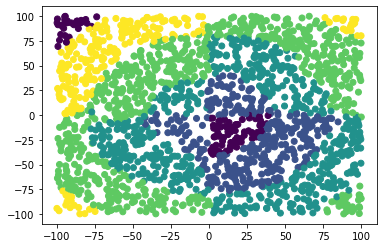

In [133]:
lossesrings52 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=-1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

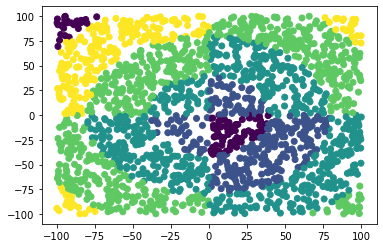

In [134]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [135]:
f1_score(Y_test.flatten(), y_pred,average="macro")

0.9560972971953914

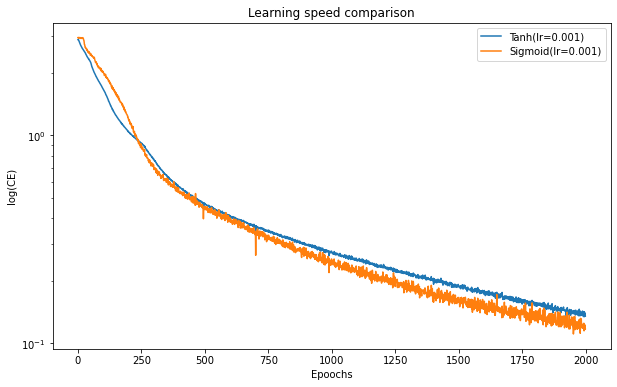

In [136]:
plt.figure(figsize=(10,6))
plt.plot(lossesrings51,label="Tanh(lr=0.001)")
plt.plot(lossesrings52,label="Sigmoid(lr=0.01)")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(CE)')
plt.yscale("log")
plt.legend()
plt.show()

# rings3-regular

In [22]:
train_df = pd.read_csv("data/rings3-regular-training.csv",index_col=0).reset_index()
test_df = pd.read_csv("data/rings3-regular-test.csv",index_col=0).reset_index()

In [23]:
X_train = np.reshape(train_df[["x","y"]].values,(len(train_df),2))
Y_train = np.reshape(train_df["c"].values,(len(train_df),1))

In [24]:
X_test = np.reshape(test_df[["x","y"]].values,(len(test_df),2))
Y_test = np.reshape(test_df["c"].values,(len(test_df),1))

#### Normalize the data

In [25]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### tanh

In [76]:
nn = NeuralNetwork(2,[20,3],["tanh","softmax"],["uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001)

In [77]:
y_train = makey_rings3(Y_train)
nn.fit(X_train_std.copy(), y_train, epochs = 2000, batch_size = 32)

Epoch 1/2000 - loss: 3.967298586083193
Epoch 2/2000 - loss: 3.7720871239666214
Epoch 3/2000 - loss: 3.7143273726542523
Epoch 4/2000 - loss: 3.682384585266089
Epoch 5/2000 - loss: 3.6597306223067942
Epoch 6/2000 - loss: 3.651396092936139
Epoch 7/2000 - loss: 3.623828319067015
Epoch 8/2000 - loss: 3.611961908288768
Epoch 9/2000 - loss: 3.602852651993591
Epoch 10/2000 - loss: 3.6067246036343334
Epoch 11/2000 - loss: 3.5702624461564687
Epoch 12/2000 - loss: 3.5681532771250812
Epoch 13/2000 - loss: 3.55474612174552
Epoch 14/2000 - loss: 3.5470360278161706
Epoch 15/2000 - loss: 3.5358439560153365
Epoch 16/2000 - loss: 3.503692431656578
Epoch 17/2000 - loss: 3.498965565302728
Epoch 18/2000 - loss: 3.486205356377772
Epoch 19/2000 - loss: 3.473309282354446
Epoch 20/2000 - loss: 3.4636744926780745
Epoch 21/2000 - loss: 3.4443118865026214
Epoch 22/2000 - loss: 3.4292014853763
Epoch 23/2000 - loss: 3.417669811825663
Epoch 24/2000 - loss: 3.3893708075072815
Epoch 25/2000 - loss: 3.3829775363493835


Epoch 202/2000 - loss: 1.4153028303862485
Epoch 203/2000 - loss: 1.4101370095015513
Epoch 204/2000 - loss: 1.4088634616969944
Epoch 205/2000 - loss: 1.405172981583038
Epoch 206/2000 - loss: 1.3996807658577652
Epoch 207/2000 - loss: 1.3899029344946696
Epoch 208/2000 - loss: 1.3911945643453068
Epoch 209/2000 - loss: 1.3828099204931372
Epoch 210/2000 - loss: 1.3852620182820052
Epoch 211/2000 - loss: 1.3805672090996504
Epoch 212/2000 - loss: 1.375055394060464
Epoch 213/2000 - loss: 1.3733483614660196
Epoch 214/2000 - loss: 1.3700925897451293
Epoch 215/2000 - loss: 1.364891696331265
Epoch 216/2000 - loss: 1.362782961307065
Epoch 217/2000 - loss: 1.3572581266695858
Epoch 218/2000 - loss: 1.3545346647369725
Epoch 219/2000 - loss: 1.3496822179819796
Epoch 220/2000 - loss: 1.3441099094225009
Epoch 221/2000 - loss: 1.344753068421097
Epoch 222/2000 - loss: 1.3374571445496926
Epoch 223/2000 - loss: 1.339668951917245
Epoch 224/2000 - loss: 1.3315569221021077
Epoch 225/2000 - loss: 1.325089524917537

Epoch 400/2000 - loss: 0.9438913058899494
Epoch 401/2000 - loss: 0.9436377720761745
Epoch 402/2000 - loss: 0.9444319575442187
Epoch 403/2000 - loss: 0.9391901824484594
Epoch 404/2000 - loss: 0.9404945487257051
Epoch 405/2000 - loss: 0.9384446095758209
Epoch 406/2000 - loss: 0.9408064340958749
Epoch 407/2000 - loss: 0.9351179639911321
Epoch 408/2000 - loss: 0.9366284874204567
Epoch 409/2000 - loss: 0.9344582171732917
Epoch 410/2000 - loss: 0.9331566135841264
Epoch 411/2000 - loss: 0.9288289978511671
Epoch 412/2000 - loss: 0.9300601278751235
Epoch 413/2000 - loss: 0.9279165719763959
Epoch 414/2000 - loss: 0.9280139557978623
Epoch 415/2000 - loss: 0.9286156494409022
Epoch 416/2000 - loss: 0.9220259084293535
Epoch 417/2000 - loss: 0.9225306307114127
Epoch 418/2000 - loss: 0.9228163448504954
Epoch 419/2000 - loss: 0.9197439135613841
Epoch 420/2000 - loss: 0.9220411360177709
Epoch 421/2000 - loss: 0.9180308621070953
Epoch 422/2000 - loss: 0.9181002727367746
Epoch 423/2000 - loss: 0.914994279

Epoch 597/2000 - loss: 0.7641888375300513
Epoch 598/2000 - loss: 0.7617384420100028
Epoch 599/2000 - loss: 0.7611078244538029
Epoch 600/2000 - loss: 0.7629306100296417
Epoch 601/2000 - loss: 0.7577580266411552
Epoch 602/2000 - loss: 0.7572981334799499
Epoch 603/2000 - loss: 0.7575593646299531
Epoch 604/2000 - loss: 0.7588582457249565
Epoch 605/2000 - loss: 0.758744986628013
Epoch 606/2000 - loss: 0.7553867051652596
Epoch 607/2000 - loss: 0.7549220907183835
Epoch 608/2000 - loss: 0.7565378138643835
Epoch 609/2000 - loss: 0.7557246193433487
Epoch 610/2000 - loss: 0.7538548477557366
Epoch 611/2000 - loss: 0.75555509083538
Epoch 612/2000 - loss: 0.7520990854508885
Epoch 613/2000 - loss: 0.7523638737839885
Epoch 614/2000 - loss: 0.7518073941379636
Epoch 615/2000 - loss: 0.7521060960565112
Epoch 616/2000 - loss: 0.7507817816655521
Epoch 617/2000 - loss: 0.75001844439911
Epoch 618/2000 - loss: 0.74981926709339
Epoch 619/2000 - loss: 0.7469490298795269
Epoch 620/2000 - loss: 0.7484258953676292

Epoch 793/2000 - loss: 0.6614444976580915
Epoch 794/2000 - loss: 0.6645623199160802
Epoch 795/2000 - loss: 0.662405465428157
Epoch 796/2000 - loss: 0.6667702245172943
Epoch 797/2000 - loss: 0.6640833410079718
Epoch 798/2000 - loss: 0.6622103689498399
Epoch 799/2000 - loss: 0.661326608339174
Epoch 800/2000 - loss: 0.6607136608496618
Epoch 801/2000 - loss: 0.6629045145183151
Epoch 802/2000 - loss: 0.6621987501486393
Epoch 803/2000 - loss: 0.6593991879304077
Epoch 804/2000 - loss: 0.6583587428438935
Epoch 805/2000 - loss: 0.6616625655057335
Epoch 806/2000 - loss: 0.6588848042721418
Epoch 807/2000 - loss: 0.6564337580776174
Epoch 808/2000 - loss: 0.6564643438196474
Epoch 809/2000 - loss: 0.6597832621077463
Epoch 810/2000 - loss: 0.657465086993124
Epoch 811/2000 - loss: 0.6560725458067744
Epoch 812/2000 - loss: 0.6562496737653635
Epoch 813/2000 - loss: 0.6567986956805999
Epoch 814/2000 - loss: 0.6562592147388994
Epoch 815/2000 - loss: 0.657186315714515
Epoch 816/2000 - loss: 0.6568808830173

Epoch 990/2000 - loss: 0.5988624846740179
Epoch 991/2000 - loss: 0.6015065150779705
Epoch 992/2000 - loss: 0.5982949182150994
Epoch 993/2000 - loss: 0.5946136410456164
Epoch 994/2000 - loss: 0.5981550245389129
Epoch 995/2000 - loss: 0.5962009086229776
Epoch 996/2000 - loss: 0.5985517656966802
Epoch 997/2000 - loss: 0.5962455721855124
Epoch 998/2000 - loss: 0.598794236464077
Epoch 999/2000 - loss: 0.5983699544873057
Epoch 1000/2000 - loss: 0.5980730721549502
Epoch 1001/2000 - loss: 0.595288222410898
Epoch 1002/2000 - loss: 0.5938442567353694
Epoch 1003/2000 - loss: 0.5936550758231219
Epoch 1004/2000 - loss: 0.5964722718060538
Epoch 1005/2000 - loss: 0.5939314662735568
Epoch 1006/2000 - loss: 0.5952027012212832
Epoch 1007/2000 - loss: 0.5968505048500877
Epoch 1008/2000 - loss: 0.595104153187978
Epoch 1009/2000 - loss: 0.5923550947859264
Epoch 1010/2000 - loss: 0.5888557032027386
Epoch 1011/2000 - loss: 0.5942701532980862
Epoch 1012/2000 - loss: 0.5925029654785243
Epoch 1013/2000 - loss: 

Epoch 1182/2000 - loss: 0.5442899205425176
Epoch 1183/2000 - loss: 0.5542096467854855
Epoch 1184/2000 - loss: 0.548096607860774
Epoch 1185/2000 - loss: 0.5497784265264022
Epoch 1186/2000 - loss: 0.5497105658949588
Epoch 1187/2000 - loss: 0.5439430854259731
Epoch 1188/2000 - loss: 0.5487672501574264
Epoch 1189/2000 - loss: 0.5485942226384187
Epoch 1190/2000 - loss: 0.5463553323846941
Epoch 1191/2000 - loss: 0.5467269194107701
Epoch 1192/2000 - loss: 0.5492047237838146
Epoch 1193/2000 - loss: 0.5496434111072213
Epoch 1194/2000 - loss: 0.547568002582642
Epoch 1195/2000 - loss: 0.5461665189335153
Epoch 1196/2000 - loss: 0.545792297749722
Epoch 1197/2000 - loss: 0.5495692489556084
Epoch 1198/2000 - loss: 0.5457875200354707
Epoch 1199/2000 - loss: 0.5451045541592066
Epoch 1200/2000 - loss: 0.543355814004974
Epoch 1201/2000 - loss: 0.5434161497891601
Epoch 1202/2000 - loss: 0.5437677827674985
Epoch 1203/2000 - loss: 0.5448317603272693
Epoch 1204/2000 - loss: 0.5459852592686627
Epoch 1205/2000

Epoch 1374/2000 - loss: 0.5058459648368767
Epoch 1375/2000 - loss: 0.5071268554732424
Epoch 1376/2000 - loss: 0.5125217816610642
Epoch 1377/2000 - loss: 0.5063403321779857
Epoch 1378/2000 - loss: 0.5079283915534663
Epoch 1379/2000 - loss: 0.5083211431781738
Epoch 1380/2000 - loss: 0.5080638650713967
Epoch 1381/2000 - loss: 0.5083486145999085
Epoch 1382/2000 - loss: 0.5094609251615801
Epoch 1383/2000 - loss: 0.505677406707068
Epoch 1384/2000 - loss: 0.5096364107042052
Epoch 1385/2000 - loss: 0.5105474909001033
Epoch 1386/2000 - loss: 0.5052244763908861
Epoch 1387/2000 - loss: 0.5055504070691197
Epoch 1388/2000 - loss: 0.5066801018455143
Epoch 1389/2000 - loss: 0.5063404432781495
Epoch 1390/2000 - loss: 0.5078090858870795
Epoch 1391/2000 - loss: 0.5051022757940958
Epoch 1392/2000 - loss: 0.5035578569209113
Epoch 1393/2000 - loss: 0.5062455214402729
Epoch 1394/2000 - loss: 0.5046635513598531
Epoch 1395/2000 - loss: 0.5055541673794126
Epoch 1396/2000 - loss: 0.5033678538353116
Epoch 1397/2

Epoch 1564/2000 - loss: 0.4735980350169363
Epoch 1565/2000 - loss: 0.47590544174435995
Epoch 1566/2000 - loss: 0.47234830269902944
Epoch 1567/2000 - loss: 0.47530793649387126
Epoch 1568/2000 - loss: 0.4736587400265883
Epoch 1569/2000 - loss: 0.4738964444370324
Epoch 1570/2000 - loss: 0.47244844796397945
Epoch 1571/2000 - loss: 0.4709449295647133
Epoch 1572/2000 - loss: 0.47150221767209366
Epoch 1573/2000 - loss: 0.47238518298389376
Epoch 1574/2000 - loss: 0.47207230876049655
Epoch 1575/2000 - loss: 0.47400156928226755
Epoch 1576/2000 - loss: 0.47177590635753
Epoch 1577/2000 - loss: 0.4715430439757372
Epoch 1578/2000 - loss: 0.4712455562309121
Epoch 1579/2000 - loss: 0.47497121835032846
Epoch 1580/2000 - loss: 0.4702712554579539
Epoch 1581/2000 - loss: 0.46916473613595727
Epoch 1582/2000 - loss: 0.4680548183289768
Epoch 1583/2000 - loss: 0.47040462651275183
Epoch 1584/2000 - loss: 0.4698931566916876
Epoch 1585/2000 - loss: 0.4702055801395529
Epoch 1586/2000 - loss: 0.46843128790730576
E

Epoch 1753/2000 - loss: 0.44414555243263737
Epoch 1754/2000 - loss: 0.44432024287936045
Epoch 1755/2000 - loss: 0.44244509579426916
Epoch 1756/2000 - loss: 0.4447075313731667
Epoch 1757/2000 - loss: 0.44060687449209524
Epoch 1758/2000 - loss: 0.44479946415967364
Epoch 1759/2000 - loss: 0.44400792012843493
Epoch 1760/2000 - loss: 0.44265117692704753
Epoch 1761/2000 - loss: 0.44408711121528704
Epoch 1762/2000 - loss: 0.4402184384181632
Epoch 1763/2000 - loss: 0.4429376240954587
Epoch 1764/2000 - loss: 0.44260000474726846
Epoch 1765/2000 - loss: 0.4412987564528235
Epoch 1766/2000 - loss: 0.44344674404502926
Epoch 1767/2000 - loss: 0.44109473804849836
Epoch 1768/2000 - loss: 0.43848021632303263
Epoch 1769/2000 - loss: 0.4407227225774855
Epoch 1770/2000 - loss: 0.4432576435856628
Epoch 1771/2000 - loss: 0.44123269106098756
Epoch 1772/2000 - loss: 0.4415737110467217
Epoch 1773/2000 - loss: 0.441782896019493
Epoch 1774/2000 - loss: 0.44373019725948626
Epoch 1775/2000 - loss: 0.441801527354799

Epoch 1942/2000 - loss: 0.42280756278711706
Epoch 1943/2000 - loss: 0.4201778246151068
Epoch 1944/2000 - loss: 0.42312639556233844
Epoch 1945/2000 - loss: 0.42087754530625726
Epoch 1946/2000 - loss: 0.4195021182569752
Epoch 1947/2000 - loss: 0.42330075373543763
Epoch 1948/2000 - loss: 0.4174126460811914
Epoch 1949/2000 - loss: 0.4199588396168473
Epoch 1950/2000 - loss: 0.4207897309279373
Epoch 1951/2000 - loss: 0.4214960915097658
Epoch 1952/2000 - loss: 0.4179473402026708
Epoch 1953/2000 - loss: 0.41931528752753555
Epoch 1954/2000 - loss: 0.4211870326698935
Epoch 1955/2000 - loss: 0.4182626184938885
Epoch 1956/2000 - loss: 0.4179646409198623
Epoch 1957/2000 - loss: 0.4170098603954271
Epoch 1958/2000 - loss: 0.4199083456017047
Epoch 1959/2000 - loss: 0.4204304843224486
Epoch 1960/2000 - loss: 0.4189777761493337
Epoch 1961/2000 - loss: 0.41808456674026206
Epoch 1962/2000 - loss: 0.42081763217986856
Epoch 1963/2000 - loss: 0.42014914750540416
Epoch 1964/2000 - loss: 0.4191561801032995
Epo

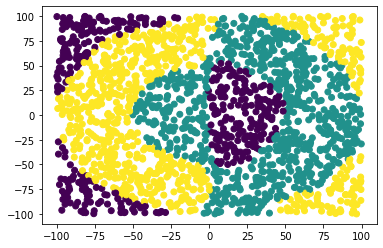

In [82]:
lossesrings31 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

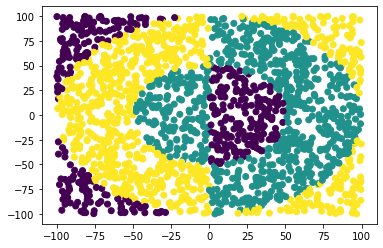

In [83]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [84]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.9596813144545658

### ReLU

In [71]:
nn = NeuralNetwork(2,[20,3],["relu","softmax"],["uniform","uniform"])
nn.compile(loss = "CE", optimizer= "BGD", lr = 0.001)

In [72]:
y_train = makey_rings3(Y_train)
nn.fit(X_train_std.copy(), y_train, epochs = 2000, batch_size = 32)

Epoch 1/2000 - loss: 4.057608306956157
Epoch 2/2000 - loss: 3.8827857672906076
Epoch 3/2000 - loss: 3.808267729068037
Epoch 4/2000 - loss: 3.7635676672035947
Epoch 5/2000 - loss: 3.7321535555181797
Epoch 6/2000 - loss: 3.7188111820539813
Epoch 7/2000 - loss: 3.6883570456416037
Epoch 8/2000 - loss: 3.6597545135578016
Epoch 9/2000 - loss: 3.6344706084322573
Epoch 10/2000 - loss: 3.623724877177568
Epoch 11/2000 - loss: 3.5893509846310416
Epoch 12/2000 - loss: 3.5746640715000986
Epoch 13/2000 - loss: 3.5498675528405044
Epoch 14/2000 - loss: 3.5440953652176184
Epoch 15/2000 - loss: 3.5221931301739473
Epoch 16/2000 - loss: 3.4895681404123935
Epoch 17/2000 - loss: 3.480137902689851
Epoch 18/2000 - loss: 3.4646060235134155
Epoch 19/2000 - loss: 3.4521841574607115
Epoch 20/2000 - loss: 3.440964583577336
Epoch 21/2000 - loss: 3.4157266842718257
Epoch 22/2000 - loss: 3.402238598053064
Epoch 23/2000 - loss: 3.3882484865622575
Epoch 24/2000 - loss: 3.3633305464514507
Epoch 25/2000 - loss: 3.3483601

Epoch 202/2000 - loss: 1.471566440812594
Epoch 203/2000 - loss: 1.4670046161319097
Epoch 204/2000 - loss: 1.4710251310588918
Epoch 205/2000 - loss: 1.4682187001472904
Epoch 206/2000 - loss: 1.4647954256976454
Epoch 207/2000 - loss: 1.4518183477822297
Epoch 208/2000 - loss: 1.4424588763400412
Epoch 209/2000 - loss: 1.4465542590338445
Epoch 210/2000 - loss: 1.4347704954791045
Epoch 211/2000 - loss: 1.4373576359236213
Epoch 212/2000 - loss: 1.4324375389299526
Epoch 213/2000 - loss: 1.4300049021158505
Epoch 214/2000 - loss: 1.4264901848429066
Epoch 215/2000 - loss: 1.4276965533090236
Epoch 216/2000 - loss: 1.4218209452017796
Epoch 217/2000 - loss: 1.4129342930004674
Epoch 218/2000 - loss: 1.416661730904051
Epoch 219/2000 - loss: 1.4082444995417014
Epoch 220/2000 - loss: 1.4001096972042426
Epoch 221/2000 - loss: 1.4055756407630695
Epoch 222/2000 - loss: 1.3938908977567364
Epoch 223/2000 - loss: 1.3883822018480378
Epoch 224/2000 - loss: 1.38703454776652
Epoch 225/2000 - loss: 1.3675880699684

Epoch 399/2000 - loss: 0.9738077605891251
Epoch 400/2000 - loss: 0.9791667109900154
Epoch 401/2000 - loss: 0.962581126501637
Epoch 402/2000 - loss: 0.9896752218484223
Epoch 403/2000 - loss: 0.9809147136290723
Epoch 404/2000 - loss: 0.9672216622687637
Epoch 405/2000 - loss: 0.9774575351505497
Epoch 406/2000 - loss: 0.9829174030319802
Epoch 407/2000 - loss: 0.9571897989296712
Epoch 408/2000 - loss: 0.9718721413249117
Epoch 409/2000 - loss: 0.9584539359720871
Epoch 410/2000 - loss: 0.9619431412587469
Epoch 411/2000 - loss: 0.9536269404214796
Epoch 412/2000 - loss: 0.9587578753992
Epoch 413/2000 - loss: 0.9617447470678303
Epoch 414/2000 - loss: 0.9664457636357225
Epoch 415/2000 - loss: 0.9628754303245151
Epoch 416/2000 - loss: 0.954948992743358
Epoch 417/2000 - loss: 0.940110508675206
Epoch 418/2000 - loss: 0.9458105746039609
Epoch 419/2000 - loss: 0.9739868235567568
Epoch 420/2000 - loss: 0.9788909858467418
Epoch 421/2000 - loss: 0.9411535674242203
Epoch 422/2000 - loss: 0.959002058768448

Epoch 595/2000 - loss: 0.7965010115071394
Epoch 596/2000 - loss: 0.8190069476250242
Epoch 597/2000 - loss: 0.8157352338500361
Epoch 598/2000 - loss: 0.8218228375042511
Epoch 599/2000 - loss: 0.7980068945748731
Epoch 600/2000 - loss: 0.812902583815484
Epoch 601/2000 - loss: 0.7962463723581382
Epoch 602/2000 - loss: 0.8061917166379828
Epoch 603/2000 - loss: 0.782725442064292
Epoch 604/2000 - loss: 0.7930112328228842
Epoch 605/2000 - loss: 0.8120900595401612
Epoch 606/2000 - loss: 0.7862314794828396
Epoch 607/2000 - loss: 0.818325016963087
Epoch 608/2000 - loss: 0.8184127386691681
Epoch 609/2000 - loss: 0.7979763081711866
Epoch 610/2000 - loss: 0.7986815525313444
Epoch 611/2000 - loss: 0.8067949341849386
Epoch 612/2000 - loss: 0.7858825133068632
Epoch 613/2000 - loss: 0.7972219977231041
Epoch 614/2000 - loss: 0.7845902408118595
Epoch 615/2000 - loss: 0.7988724141653823
Epoch 616/2000 - loss: 0.7993699762357497
Epoch 617/2000 - loss: 0.8186531621126063
Epoch 618/2000 - loss: 0.807252737587

Epoch 791/2000 - loss: 0.7059687472621865
Epoch 792/2000 - loss: 0.7047456637971277
Epoch 793/2000 - loss: 0.7032309698584701
Epoch 794/2000 - loss: 0.7060494735672568
Epoch 795/2000 - loss: 0.7086851525126553
Epoch 796/2000 - loss: 0.7139454487337719
Epoch 797/2000 - loss: 0.7092172124626567
Epoch 798/2000 - loss: 0.7209117117370404
Epoch 799/2000 - loss: 0.7143347700336652
Epoch 800/2000 - loss: 0.7203387109671024
Epoch 801/2000 - loss: 0.720629290199021
Epoch 802/2000 - loss: 0.7089570862030655
Epoch 803/2000 - loss: 0.7079475956392447
Epoch 804/2000 - loss: 0.7111448157883683
Epoch 805/2000 - loss: 0.6963417291769215
Epoch 806/2000 - loss: 0.707255768434344
Epoch 807/2000 - loss: 0.6985063672482421
Epoch 808/2000 - loss: 0.7053856539177252
Epoch 809/2000 - loss: 0.7167068859501331
Epoch 810/2000 - loss: 0.7130066338741173
Epoch 811/2000 - loss: 0.7055558845576668
Epoch 812/2000 - loss: 0.7134463444896523
Epoch 813/2000 - loss: 0.7028752445413451
Epoch 814/2000 - loss: 0.69951826980

Epoch 987/2000 - loss: 0.6495848242480883
Epoch 988/2000 - loss: 0.6659122938583917
Epoch 989/2000 - loss: 0.6687612118576279
Epoch 990/2000 - loss: 0.6603888148143678
Epoch 991/2000 - loss: 0.6624151801051806
Epoch 992/2000 - loss: 0.6642486354666526
Epoch 993/2000 - loss: 0.6486154294387615
Epoch 994/2000 - loss: 0.6589259269093358
Epoch 995/2000 - loss: 0.6549534749192565
Epoch 996/2000 - loss: 0.6553054270936807
Epoch 997/2000 - loss: 0.6540531143438503
Epoch 998/2000 - loss: 0.6873192235465735
Epoch 999/2000 - loss: 0.6657791276888764
Epoch 1000/2000 - loss: 0.6837687335729655
Epoch 1001/2000 - loss: 0.6439517328975829
Epoch 1002/2000 - loss: 0.6401259967090758
Epoch 1003/2000 - loss: 0.662952889399087
Epoch 1004/2000 - loss: 0.6597024315582114
Epoch 1005/2000 - loss: 0.6361768185517671
Epoch 1006/2000 - loss: 0.6662407171574701
Epoch 1007/2000 - loss: 0.6528866948918336
Epoch 1008/2000 - loss: 0.6589889300204625
Epoch 1009/2000 - loss: 0.6456159626260453
Epoch 1010/2000 - loss: 0

Epoch 1180/2000 - loss: 0.595995429158209
Epoch 1181/2000 - loss: 0.6283208547072682
Epoch 1182/2000 - loss: 0.6069812216239237
Epoch 1183/2000 - loss: 0.6149020663476463
Epoch 1184/2000 - loss: 0.5974088052748442
Epoch 1185/2000 - loss: 0.6049331020119492
Epoch 1186/2000 - loss: 0.60740607429888
Epoch 1187/2000 - loss: 0.5918689011786952
Epoch 1188/2000 - loss: 0.6048822554020323
Epoch 1189/2000 - loss: 0.6160082736274957
Epoch 1190/2000 - loss: 0.5994385853995273
Epoch 1191/2000 - loss: 0.6016785217778645
Epoch 1192/2000 - loss: 0.6149557583489718
Epoch 1193/2000 - loss: 0.6187917129099584
Epoch 1194/2000 - loss: 0.6078495890419554
Epoch 1195/2000 - loss: 0.5933761008292632
Epoch 1196/2000 - loss: 0.6168451201935308
Epoch 1197/2000 - loss: 0.5996361910367369
Epoch 1198/2000 - loss: 0.5921656379992719
Epoch 1199/2000 - loss: 0.605120943133753
Epoch 1200/2000 - loss: 0.6001112584522439
Epoch 1201/2000 - loss: 0.5986256635375335
Epoch 1202/2000 - loss: 0.5943286307718553
Epoch 1203/2000

Epoch 1372/2000 - loss: 0.5900650959561338
Epoch 1373/2000 - loss: 0.5659887455150321
Epoch 1374/2000 - loss: 0.5568256540153343
Epoch 1375/2000 - loss: 0.5835783707663061
Epoch 1376/2000 - loss: 0.5820719489030691
Epoch 1377/2000 - loss: 0.5679639834445039
Epoch 1378/2000 - loss: 0.576334452492008
Epoch 1379/2000 - loss: 0.5588991150241367
Epoch 1380/2000 - loss: 0.5760443104132034
Epoch 1381/2000 - loss: 0.5796637016443692
Epoch 1382/2000 - loss: 0.5878401332708129
Epoch 1383/2000 - loss: 0.5696455665687489
Epoch 1384/2000 - loss: 0.573900686496354
Epoch 1385/2000 - loss: 0.5969027208529682
Epoch 1386/2000 - loss: 0.5876019007164032
Epoch 1387/2000 - loss: 0.5655336715473677
Epoch 1388/2000 - loss: 0.5818471121739125
Epoch 1389/2000 - loss: 0.5697626867201336
Epoch 1390/2000 - loss: 0.5664427274345314
Epoch 1391/2000 - loss: 0.5894830659507401
Epoch 1392/2000 - loss: 0.5667243002281955
Epoch 1393/2000 - loss: 0.5941757526773388
Epoch 1394/2000 - loss: 0.5807184632580079
Epoch 1395/20

Epoch 1564/2000 - loss: 0.5466299631092199
Epoch 1565/2000 - loss: 0.5463362497140246
Epoch 1566/2000 - loss: 0.52521678025565
Epoch 1567/2000 - loss: 0.5433938331322495
Epoch 1568/2000 - loss: 0.5566600675644915
Epoch 1569/2000 - loss: 0.5455505824479564
Epoch 1570/2000 - loss: 0.5442578661719197
Epoch 1571/2000 - loss: 0.541455891905437
Epoch 1572/2000 - loss: 0.5256192046325178
Epoch 1573/2000 - loss: 0.5432074695449778
Epoch 1574/2000 - loss: 0.5410554386861307
Epoch 1575/2000 - loss: 0.5546439639361035
Epoch 1576/2000 - loss: 0.5427332864788715
Epoch 1577/2000 - loss: 0.532619280071669
Epoch 1578/2000 - loss: 0.5445859409691881
Epoch 1579/2000 - loss: 0.5965855004785011
Epoch 1580/2000 - loss: 0.5231491421729445
Epoch 1581/2000 - loss: 0.5345012455465867
Epoch 1582/2000 - loss: 0.547657339322795
Epoch 1583/2000 - loss: 0.5463939773052867
Epoch 1584/2000 - loss: 0.5389507743209742
Epoch 1585/2000 - loss: 0.53955504131643
Epoch 1586/2000 - loss: 0.54194230736538
Epoch 1587/2000 - lo

Epoch 1757/2000 - loss: 0.5123095020560515
Epoch 1758/2000 - loss: 0.5423044013369256
Epoch 1759/2000 - loss: 0.5349405512882299
Epoch 1760/2000 - loss: 0.5127983971004307
Epoch 1761/2000 - loss: 0.5195017363803068
Epoch 1762/2000 - loss: 0.5153885757601828
Epoch 1763/2000 - loss: 0.5156847086603805
Epoch 1764/2000 - loss: 0.5239727878287459
Epoch 1765/2000 - loss: 0.5236665685823343
Epoch 1766/2000 - loss: 0.5444449228136866
Epoch 1767/2000 - loss: 0.5226715189817545
Epoch 1768/2000 - loss: 0.504353298178061
Epoch 1769/2000 - loss: 0.5273088302071391
Epoch 1770/2000 - loss: 0.5169011895238977
Epoch 1771/2000 - loss: 0.5362275339094205
Epoch 1772/2000 - loss: 0.515189220114161
Epoch 1773/2000 - loss: 0.5235553132252302
Epoch 1774/2000 - loss: 0.5731803101398792
Epoch 1775/2000 - loss: 0.5293260212800639
Epoch 1776/2000 - loss: 0.5047884262455923
Epoch 1777/2000 - loss: 0.5382135404862955
Epoch 1778/2000 - loss: 0.5125158013700273
Epoch 1779/2000 - loss: 0.5055436438025195
Epoch 1780/20

Epoch 1949/2000 - loss: 0.48565825456772593
Epoch 1950/2000 - loss: 0.4992775382966976
Epoch 1951/2000 - loss: 0.5079358170278367
Epoch 1952/2000 - loss: 0.4848515544339653
Epoch 1953/2000 - loss: 0.4980708695206139
Epoch 1954/2000 - loss: 0.51435195829201
Epoch 1955/2000 - loss: 0.49091057595305737
Epoch 1956/2000 - loss: 0.5006735381027485
Epoch 1957/2000 - loss: 0.49182889048201933
Epoch 1958/2000 - loss: 0.5262167007438047
Epoch 1959/2000 - loss: 0.5138119488599004
Epoch 1960/2000 - loss: 0.4962120082261202
Epoch 1961/2000 - loss: 0.4961356808628427
Epoch 1962/2000 - loss: 0.5189362436487871
Epoch 1963/2000 - loss: 0.5283629913617071
Epoch 1964/2000 - loss: 0.5108136842928984
Epoch 1965/2000 - loss: 0.5120735525394492
Epoch 1966/2000 - loss: 0.5101792177788858
Epoch 1967/2000 - loss: 0.5081323972449494
Epoch 1968/2000 - loss: 0.5064163672103351
Epoch 1969/2000 - loss: 0.5134407508898047
Epoch 1970/2000 - loss: 0.48253443556846126
Epoch 1971/2000 - loss: 0.5102356592066968
Epoch 197

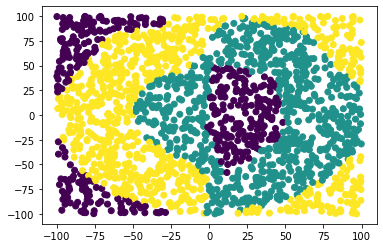

In [73]:
lossesrings32 = nn.losses
y_pred = nn.predict(X_test_std)
y_pred = np.argmax(y_pred,axis=1)
plt.scatter(X_test[:,0], X_test[:,1],c=y_pred)
plt.show()

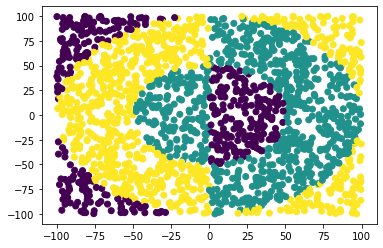

In [74]:
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

In [75]:
f1_score(Y_test.reshape(1,-1).flatten(), y_pred,average="macro")

0.9535470119713855

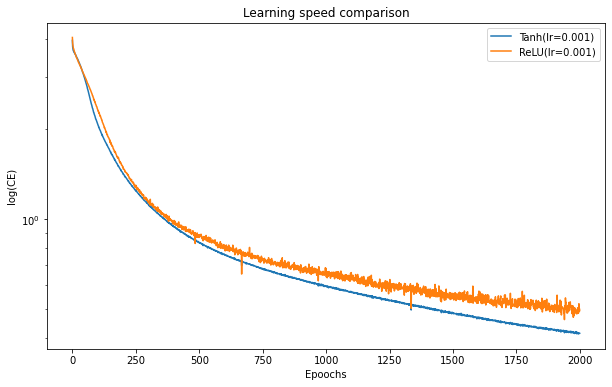

In [85]:
plt.figure(figsize=(10,6))
plt.plot(lossesrings31,label="Tanh(lr=0.001)")
plt.plot(lossesrings32,label="ReLU(lr=0.001)")
plt.title('Learning speed comparison')
plt.xlabel('Epoochs')
plt.ylabel('log(CE)')
plt.yscale("log")
plt.legend()
plt.show()